In [1]:
from typing import List
import copy
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
from sklearn.neighbors import NearestNeighbors
%load_ext autoreload
%autoreload 2
import cyipopt

In [2]:
def generate_raster_scan_path(
    pos_top_left: List[float],
    pos_bottom_right: List[float],
    vertical_spacing: float,
) -> List[List[float]]:
    """
    Generate a raster (regular) scan path.

    :param pos_top_left: list[float, float]. Top left vertex of the scan
        grid in pixel. Coordinates are defined with regards to the support.
    :param pos_bottom_right: list[float, float]. Bottom right vertex of the
        scan grid in pixel.
    :param vertical_spacing: float. Spacing of adjacent scan lines in pixel.
    :return: list[list[float, float]]. A list of vertices that define the
        scan path.
    """
    # Indicates whether the current vertex is on the left or right of the grid.
    current_side = 0
    current_point = copy.deepcopy(np.array(pos_top_left))
    generated_path = []
    generated_path.append(copy.deepcopy(current_point))
    while True:
        if current_side == 0:
            current_point[1] = pos_bottom_right[1]
        else:
            current_point[1] = pos_top_left[1]
        current_side = 1 - current_side
        generated_path.append(copy.deepcopy(current_point))
        if current_point[0] + vertical_spacing > pos_bottom_right[0]:
            break
        current_point[0] += vertical_spacing
        generated_path.append(copy.deepcopy(current_point))
    generated_path = np.stack(generated_path)

    dead_segment_mask = np.ones(len(generated_path) - 1, dtype="bool")
    dead_segment_mask[1::2] = False
    return generated_path, dead_segment_mask
    # if self.return_coordinates_type == "nm":
    #     return self.generated_path * self.psize_nm
    # return self.generated_path

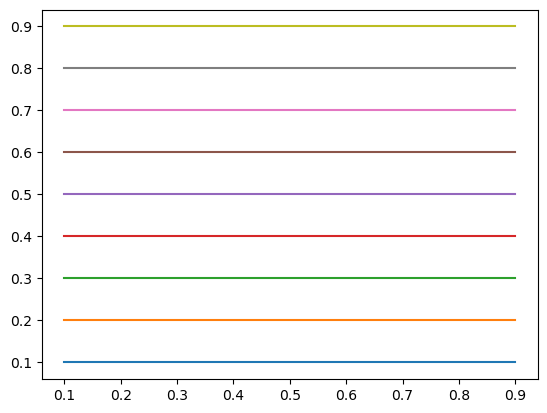

In [3]:
path, mask = generate_raster_scan_path([.1, .1], [.9, .9], 0.1)

for i in range(len(mask)):
    if mask[i]:
        plt.plot(path[i:i+2,1], path[i:i+2,0])


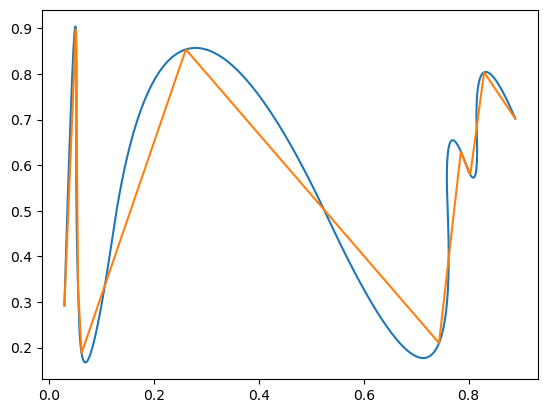

In [4]:
# vertices = np.array([[0.1, 0.1], [0.9, 0.9]])#, [0.6, 0.2], [0.2, 0.2]])

vertices = np.random.uniform(size = (10,2))
vertices[:,0] = np.sort(vertices[:,0])
time = np.linspace(0, 1, vertices.shape[0])

t = np.linspace(0,1, 1000)

interpolator = scipy.interpolate.make_interp_spline(time, vertices, k=3)

plt.figure()
# plt.plot(interpolator(t)[:, 0], interpolator(t)[:, 1], marker = '.')

interpolator = scipy.interpolate.interp1d(time, vertices.T)

# plt.figure()
# plt.plot(interpolator(t)[0,:], interpolator(t)[1,:], marker='.')

lengths = np.zeros((vertices.shape[0],))
lengths[1:] = np.linalg.norm(np.diff(vertices, axis = 0), axis = 1)
arc_time = np.cumsum(lengths)
arc_time = arc_time/arc_time[-1]
interpolator = scipy.interpolate.make_interp_spline(arc_time, vertices, k=2)
# interpolator = scipy.interpolate.make_smoothing_spline(t, vertices[:,1])
plt.plot(interpolator(t)[:, 0], interpolator(t)[:, 1])

interpolator = scipy.interpolate.make_interp_spline(arc_time, vertices, k=1)
plt.plot(interpolator(t)[:, 0], interpolator(t)[:, 1])

# interpolator = scipy.interpolate.interp1d(arc_time, vertices.T)
# plt.plot(interpolator(t)[0,:], interpolator(t)[1,:], marker='.')


In [5]:
class FlyScanPath:
    def __init__(self, vertices):
        if not isinstance(vertices, np.ndarray):
            self.vertices = np.array(vertices)
        else:
            self.vertices = vertices
        self.lengths = np.zeros((self.vertices.shape[0],))
        self.lengths[1:] = np.linalg.norm(np.diff(self.vertices, axis = 0), axis = 1)
        self.arc_length = np.cumsum(lengths)

In [6]:
import os
import tifffile
from autobl.steering import configs
from autobl.steering import measurement

image = tifffile.imread(os.path.join("tests","data", "xrf", "xrf_2idd_Cs_L.tiff"))

probe = None

sample_params = configs.SpatialSampleParams(image=image, psize_nm=1.0)
setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,
    scan_speed_nm_sec=1.0,
    exposure_sec=0.8,
    deadtime_sec=0.8,
    probe=probe,
)
measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,
    setup_params=setup_params,
    step_size_for_integration_nm=0.02,
)

measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(
        measurement_configs
    )

In [7]:
def get_sample_points(vertices, cfg, setup):
    """
    Returns list of np.ndarrays with [x,y] coordinates for each exposure
    """
    # Get arc lengths
    lengths = np.zeros((vertices.shape[0],))
    lengths[1:] = np.linalg.norm(np.diff(vertices, axis = 0), axis = 1)

    # Cumulative arc length as a paramterization
    arc_time = np.cumsum(lengths)

    # Arc length interpolator
    interpolator = scipy.interpolate.make_interp_spline(arc_time, vertices, k=1)

    # Steps
    step_size = cfg.step_size_for_integration_nm
    steps = np.arange(0, arc_time[-1], step_size)

    # Determine which points are exposed
    exposure = np.fmod(steps/setup.scan_speed_nm_sec + cfg.eps, setup.exposure_sec + setup.deadtime_sec) <= setup.exposure_sec + 2*cfg.eps

    # Which exposures for which steps
    exposure_number = ((steps + 1*cfg.eps) // (setup.exposure_sec + setup.deadtime_sec)).astype(int)

    # Put points for each exposure
    out = []
    for i in range(exposure_number[-1]):
        # out.append(np.concatenate((interpolator(steps[np.logical_and(exposure, exposure_number == i)]), exposure_number[np.logical_and(exposure, exposure_number == i),np.newaxis]), axis=1))
        out.append(interpolator(steps[np.logical_and(exposure, exposure_number == i)]))
    return out

get_sample_points(100*vertices + 20, measurement_configs, setup_params)

[array([[22.93568096, 49.20559411],
        [22.93639864, 49.22558123],
        [22.93711632, 49.24556835],
        [22.937834  , 49.26555547],
        [22.93855168, 49.28554259],
        [22.93926936, 49.30552971],
        [22.93998704, 49.32551683],
        [22.94070472, 49.34550395],
        [22.9414224 , 49.36549107],
        [22.94214009, 49.38547819],
        [22.94285777, 49.4054653 ],
        [22.94357545, 49.42545242],
        [22.94429313, 49.44543954],
        [22.94501081, 49.46542666],
        [22.94572849, 49.48541378],
        [22.94644617, 49.5054009 ],
        [22.94716385, 49.52538802],
        [22.94788153, 49.54537514],
        [22.94859921, 49.56536226],
        [22.94931689, 49.58534938],
        [22.95003457, 49.6053365 ],
        [22.95075225, 49.62532362],
        [22.95146993, 49.64531074],
        [22.95218761, 49.66529785],
        [22.95290529, 49.68528497],
        [22.95362297, 49.70527209],
        [22.95434065, 49.72525921],
        [22.95505833, 49.745

In [8]:
measurement_interface.build_sampling_points(100*vertices + 20)

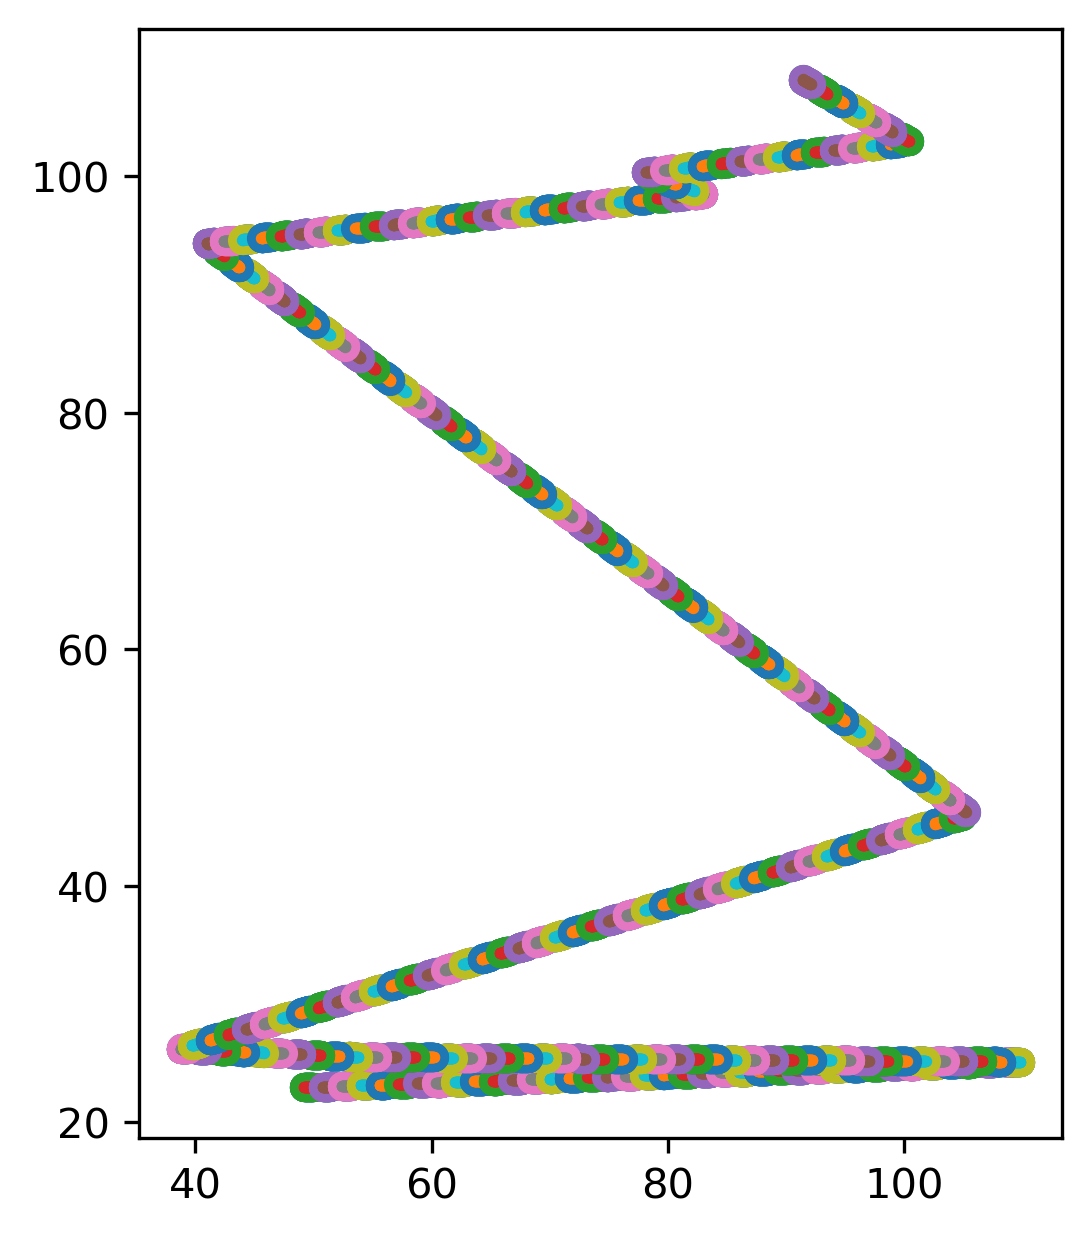

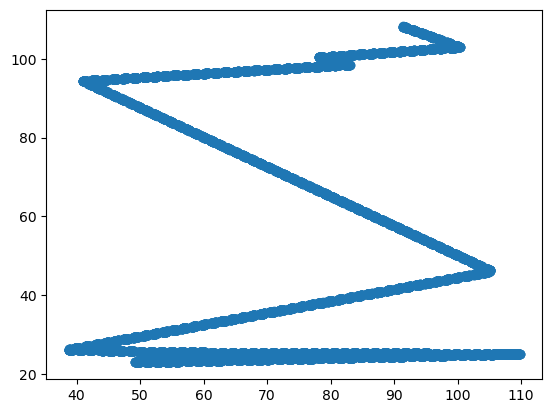

In [9]:
pts = np.concatenate(measurement_interface.points_to_sample_all_exposures, axis=0)
pts3 = measurement_interface.points_to_sample_all_exposures
# %timeit pts = np.concatenate(measurement_interface.points_to_sample_all_exposures, axis=0)
pts2 = np.concatenate(get_sample_points(100*vertices + 20, measurement_configs, setup_params), axis=0)
pts4 = get_sample_points(100*vertices + 20, measurement_configs, setup_params)
# %timeit pts2 = get_sample_points(10*vertices + 20, measurement_configs, setup_params)

fig, ax = plt.subplots(1, 1, dpi=300)
ax.scatter(pts[:, 1], pts[:, 0])
ax.scatter(pts2[:, 1], pts2[:, 0], s=0.1)

for i in range(len(pts3)):
    ax.scatter(pts3[i][:, 1], pts3[i][:, 0])
    ax.scatter(pts4[i][:, 1], pts4[i][:, 0], s = 3)

ax.set_aspect('equal')  # Set aspect ratio to equal

fig, ax = measurement_interface.plot_sampled_points()
ax.set_aspect('equal')  # Set aspect ratio to equal
ax.plot(5*vertices[:,1], 5*vertices[:,0])
plt.show()

In [10]:
import scipy.ndimage as ndi

def get_interpolated_values_from_image(image, point_list, normalize_probe=True, probe=None):
    """
    Obtain interpolated values from the image at given locations.

    :param point_list: list[list[float, float]]. List of point positions.
    :return: list[float].
    """
    if not isinstance(point_list, np.ndarray):
        point_list = np.array(point_list)
    y = point_list[:, 0]
    x = point_list[:, 1]
    if probe is None:
        # If probe function is not given, assume delta function.
        return ndi.map_coordinates(
            image, [y, x], order=1, mode="nearest"
        )
    else:
        # Prepare a list of coordinates that include n by m region around
        # each sampled point, where (n, m) is the probe shape.
        sampled_vals = []
        if normalize_probe:
            probe = probe / np.sum(probe)
        for this_y, this_x in point_list:
            # Expand around each point to capture probe area
            this_y_all = np.linspace(
                this_y - probe.shape[0] / 2.0 + 0.5,
                this_y + probe.shape[0] / 2.0 - 0.5,
                probe.shape[0],
            )
            this_x_all = np.linspace(
                this_x - probe.shape[1] / 2.0 + 0.5,
                this_x + probe.shape[1] / 2.0 - 0.5,
                probe.shape[1],
            )

            # Combine expansions in x and y to get total expanded area
            xx, yy = np.meshgrid(this_x_all, this_y_all)
            yy = yy.reshape(-1)
            xx = xx.reshape(-1)

            # Get image interpolated values from the image
            vals = ndi.map_coordinates(
                image, [yy, xx], order=1, mode="nearest"
            )
            # ... and multiply them with the probe weights
            val = np.sum(vals * probe.reshape(-1))
            sampled_vals.append(val)
        return sampled_vals

def get_interpolated_values_from_image_2(image, point_list: np.ndarray, normalize_probe: bool = True, probe=None
    ):
        """Use a convolution to simplify"""
        if not isinstance(point_list, np.ndarray):
            point_list = np.array(point_list)  # [i_sample, (y,x)]
        if probe is None:
            probe = np.ones((1, 1))
        if normalize_probe:
            probe /= np.sum(probe)
        shift = np.zeros((2,))
        if probe.shape[0] % 2 == 0:
            # even probe shape, adjust positions
            shift[0] = -0.5
        if probe.shape[1] % 2 == 0:
            shift[1] = -0.5
        probe_image = ndi.convolve(image, probe, mode="nearest")
        sampled_vals = ndi.map_coordinates(
            probe_image, point_list.T + shift[:,np.newaxis], order=1, mode="nearest"
        )
        return sampled_vals

In [11]:
probe = np.ones((4,4))

probe = probe/np.sum(probe)

a = get_interpolated_values_from_image(image, pts, probe=probe)
# %timeit a = get_interpolated_values_from_image(image, pts, probe=probe)
c = get_interpolated_values_from_image(image, pts, probe=None)

probe_image = ndi.convolve(image, probe, mode="nearest")

b = ndi.map_coordinates(probe_image, pts.T, order=1, mode="nearest")
d = get_interpolated_values_from_image_2(image, pts, probe=probe)
# %timeit d = get_interpolated_values_from_image_2(image, pts, probe=probe)

# b = get_interpolated_values_from_image(probe_image, pts, probe=None)

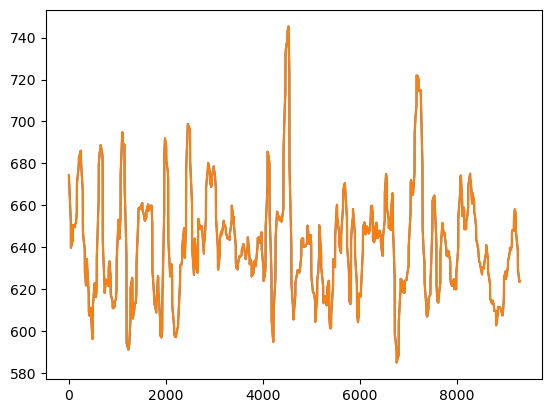

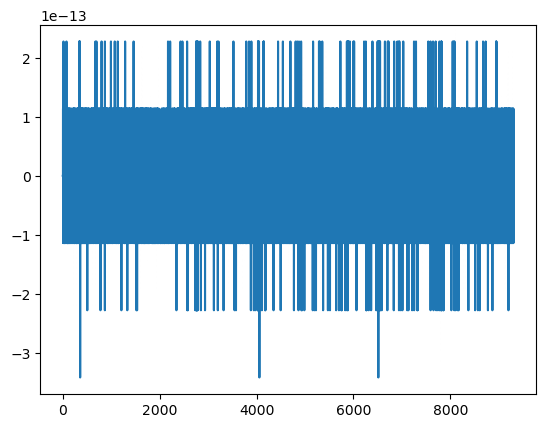

In [12]:
plt.plot(a)
# plt.plot(b)
plt.plot(d)
# plt.plot(c)

plt.figure()
plt.plot(a - d)

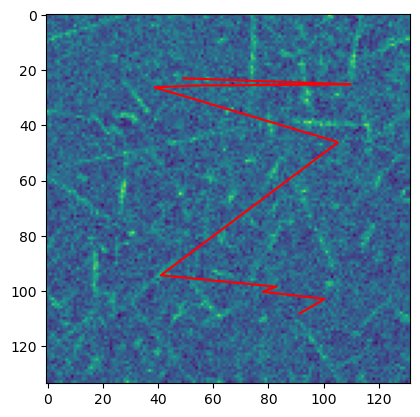

In [13]:
plt.imshow(image)
plt.plot(pts[:,1], pts[:,0], color="red")

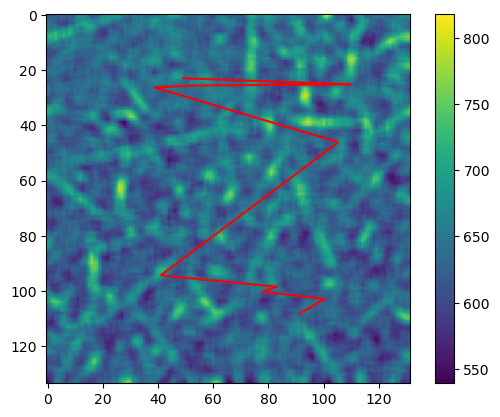

In [14]:
plt.imshow(probe_image)
plt.plot(pts[:,1], pts[:,0], color="red")
plt.colorbar()

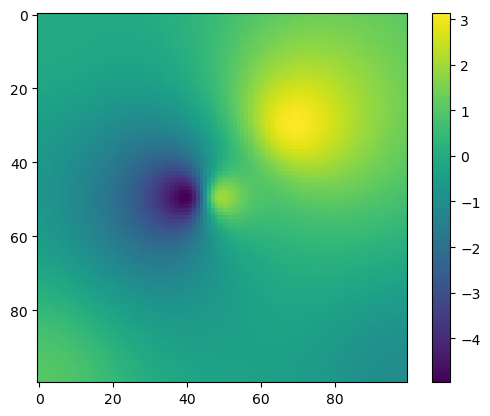

In [15]:
from scipy.spatial.distance import cdist
def idw(
    points: np.ndarray, values: np.ndarray, xi: np.ndarray, power: float = 2.0
) -> np.ndarray:
    """Inverse distance weighted interpolation

    Interpolate by weighting by inverse distance

    :param points: np.ndarray. points to interpolate between, shape (num interp
        points, dimension)
    :param values: np.ndarray. values to interpolate between, shape (num interp
        points,)
    :param xi: np.ndarray. points to get interpolated values at, shape (num
        sample points, dimension)
    :return: np.ndarray. interpolated values, shape (num sample points,)
    """
    dists = cdist(xi, points)
    # correct for zero distance
    mask = dists == 0.0
    dists[np.sum(mask, axis =1) > 0, :] = np.inf
    dists[mask] = 1.0
    # inverse distances from xi (axis = 0) to point (axis = 1)
    inv_distances = 1 / (dists ** power)
    sum_inv_distances = np.sum(inv_distances, axis=1)
    # Multiply values by inverse distances and divide by sum
    vi = np.sum(values[np.newaxis, :] * inv_distances, axis=1) / sum_inv_distances
    return vi

A = np.array([[0,0],[0,1],[1,1], [0.5, 0.5], [0.4, 0.5], [0.7, 0.3]])
VA = np.array([0, 1, -1, 2, -5, np.pi])
B = np.array([[0.1,0.1],[4,2],[-0.1,0],[0,-0.1], [1,1]])
cdist(A,B)

idw(A, VA, B)


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X,Y = np.meshgrid(x,y)
Z = idw(A, VA, np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T).reshape(X.shape)
plt.figure()
plt.imshow(Z)
plt.colorbar()

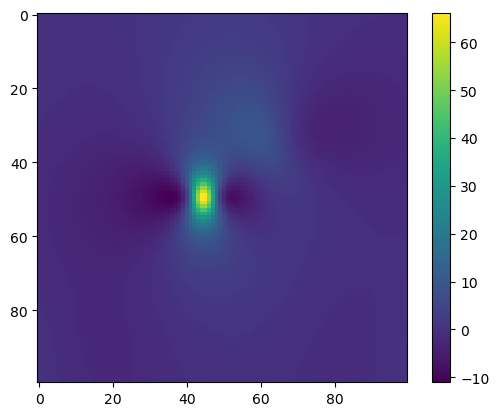

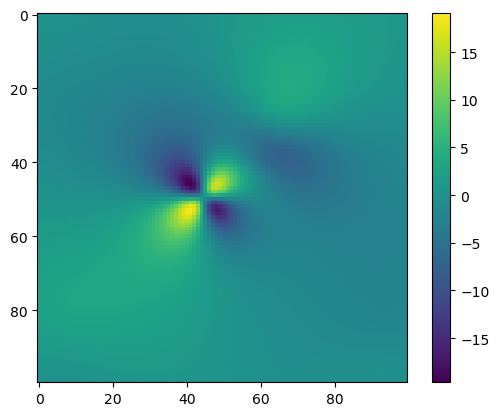

In [16]:
def idw(points, values, xi):
    """Inverse distance weighted interpolation
    """
    grad = np.zeros(xi.shape)
    dists = cdist(xi, points)
    mask = dists == 0.0
    dists[np.sum(mask, axis =1) > 0, :] = np.inf
    dists[mask] = 1.0
    # Get inverse distances from sample points -> interp points
    inv_distances = 1/dists
    # Get sum of inverse distances for each sample
    sum_inv_distances = np.sum(inv_distances, axis=1)
    # # For sample points == interp points...
    # mask = ~np.isfinite(inv_distances)
    # # ...set some values to 0.0...
    # inv_distances[~np.isfinite(sum_inv_distances),:] = 0.0
    # # ...but make sure the right values are non-zero
    # inv_distances[mask] = 1.0
    sum_inv_distances[~np.isfinite(sum_inv_distances)] = 1.0
    # Multiply values by inverse distances and divide by sum
    vi = np.sum(values[np.newaxis, :] * inv_distances, axis = 1) / sum_inv_distances
    return vi

def idw_grad(points: np.ndarray, values: np.ndarray, xi: np.ndarray, power:float = 2.0) -> np.ndarray:
    """Gradient of inverse distance weighted interpolation

    Interpolate by weighting by inverse distance

    :param points: np.ndarray. points to interpolate between, shape (num interp
        points, dimension)
    :param values: np.ndarray. values to interpolate between, shape (num interp
        points,)
    :param xi: np.ndarray. points to get gradient values at, shape (num
        sample points, dimension)
    :return: np.ndarray. gradient values, shape (num sample points,
        dimension)
    """
    grad = np.zeros(xi.shape)
    dists = cdist(xi, points)
    mask = dists == 0.0
    dists[np.sum(mask, axis =1) > 0, :] = np.inf
    dists[mask] = 1.0
    # inverse distances from xi (axis = 0) to point (axis = 1)
    inv_distances = 1 / dists
    sum_inv_distances = np.sum(inv_distances ** power, axis=1)
    # mask = ~np.isfinite(inv_distances)
    # # ...set some values to 0.0...
    # inv_distances[~np.isfinite(sum_inv_distances), :] = 0.0
    # # ...but make sure the right values are non-zero
    # inv_distances[mask] = 1.0

    inv_cubed = inv_distances**(power + 2)
    sum_val_inv_distances = np.sum(values[np.newaxis, :] * (inv_distances**power), axis=1)
    val_inv_cubed = values[np.newaxis, :] * inv_distances**(power + 2)
    diff_x = xi[:, np.newaxis, 0] - points[np.newaxis, :, 0]
    diff_y = xi[:, np.newaxis, 1] - points[np.newaxis, :, 1]

    grad[:, 0] = (
        -sum_inv_distances * np.sum(val_inv_cubed * diff_x, axis=1)
        + sum_val_inv_distances * np.sum(inv_cubed * diff_x, axis=1)
    ) / (sum_inv_distances**2)

    grad[:, 1] = (
        -sum_inv_distances * np.sum(val_inv_cubed * diff_y, axis=1)
        + sum_val_inv_distances * np.sum(inv_cubed * diff_y, axis=1)
    ) / (sum_inv_distances**2)

    return grad

A = np.array([[0,0],[0,1],[1,1], [0.5, 0.5], [0.4, 0.5], [0.7, 0.3]])
VA = np.array([0, 1, -1, 2, -5, np.pi])

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X,Y = np.meshgrid(x,y)
Z = idw_grad(A, VA, np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T)
Zx = Z[:, 0].reshape(X.shape)
Zy = Z[:, 1].reshape(X.shape)
plt.figure()
plt.imshow(Zx)
plt.colorbar()

plt.figure()
plt.imshow(Zy)
plt.colorbar()

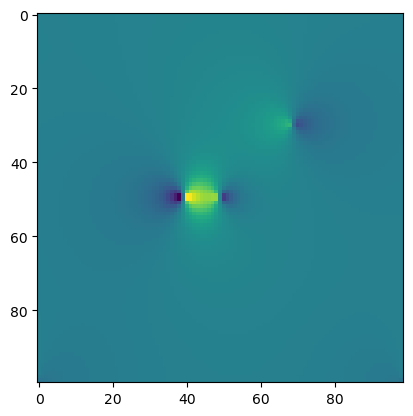

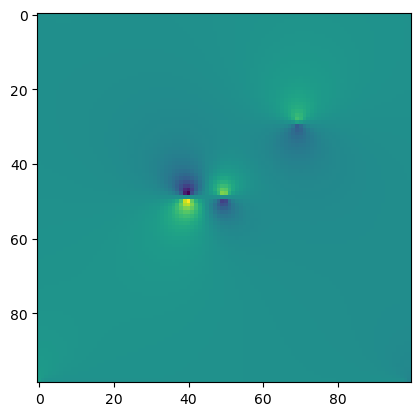

In [17]:
plt.figure()
Z = idw(A, VA, np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T).reshape(X.shape)
plt.imshow(np.diff(Z, axis = 1))

plt.figure()
plt.imshow(np.diff(Z, axis = 0))

In [18]:
import jax
import jax.numpy as jnp

In [19]:
@jax.jit
def jax_cdist(xi, points):
    return 1/jnp.sqrt(jnp.sum(jnp.square(xi[:, jnp.newaxis, :] - points[jnp.newaxis, :, :]), axis = -1))

a = jax_cdist(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A)
# %timeit a = jax_cdist(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A)
b = 1/cdist(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A)
# %timeit b = 1/cdist(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A)

[2024-08-09 13:50:24,390] Unable to initialize backend 'cuda': 
[2024-08-09 13:50:24,390] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[2024-08-09 13:50:24,392] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/flyscan/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/opt/miniconda3/envs/flyscan/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/var/folders/2x/457yjlyd2d19zw63k2w544p00000gq/T/ipykernel_96836/2652207138.py:7: RuntimeWarning: divide by zero encountered in divide
  b = 1/cdist(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A)


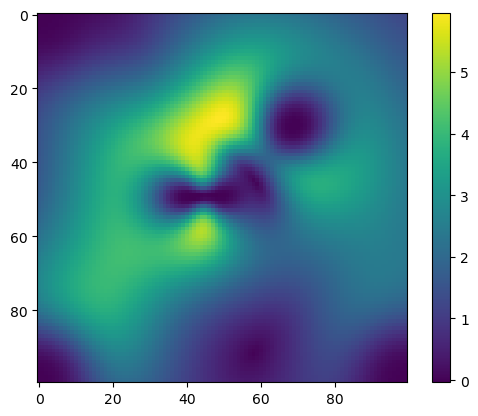

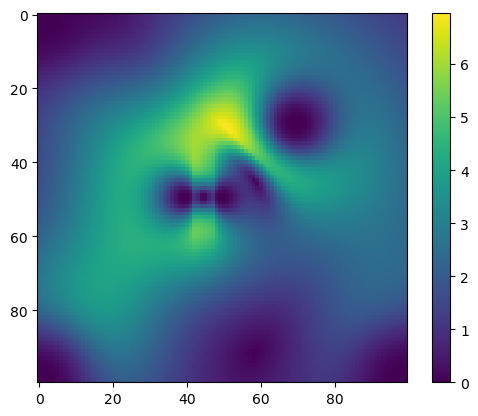

In [20]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import solve, inv
def kernel_func(xi, points, sigma = 0.1, length = 0.1):
    y_distances = squareform(pdist(points))
    rbf_y = sigma**2 * np.exp(-y_distances**2 /(2 * length**2))
    inv_y_distances = 1/(y_distances + 1e-8*np.eye(len(points)))
    # y_covar = np.exp(-y_distances**2 / (2*length**2))
    
    distances = cdist(xi, points)

    b = sigma**2 * np.exp(-distances**2 /(2 * length**2))

    # solve(y_covar, b)
    
    # return 
    return 1 - np.sum(b @ inv(rbf_y), axis= -1)
    
def kernel_func_2(xi, points, sigma = 0.1, length = 0.1):
    y_distances = squareform(pdist(points))
    rbf_y = sigma**2 * np.exp(-y_distances**2 /(2 * length**2))
    inv_y_distances = 1/(y_distances + 1e-8*np.eye(len(points)))
    # y_covar = np.exp(-y_distances**2 / (2*length**2))
    
    distances = cdist(xi, points)

    b = sigma**2 * np.exp(-distances**2 /(2 * length**2))

    # solve(y_covar, b)
    # return sigma**2 - np.sum(b/np.square(distances), axis = -1)/np.sum(1/np.square(distances), axis = -1)
    return sigma**2 - np.max(b, axis = -1)

A = np.array([[0,0],[0,1],[1,1], [0.5, 0.5], [0.4, 0.5],[0.45, 0.5], [0.7, 0.3]])
VA = np.array([0, 1, -1, 2, -5, np.pi])

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X,Y = np.meshgrid(x,y)
Z = kernel_func(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, A, sigma=1.0).reshape(X.shape)
plt.figure()
plt.imshow(Z * np.sqrt(Zx**2 + Zy**2))
plt.colorbar()

Z = kernel_func_2(
    xi =np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T,
    points = A,
    sigma=1.0
).reshape(X.shape)
plt.figure()
plt.imshow(Z * np.sqrt(Zx**2 + Zy**2))
plt.colorbar()

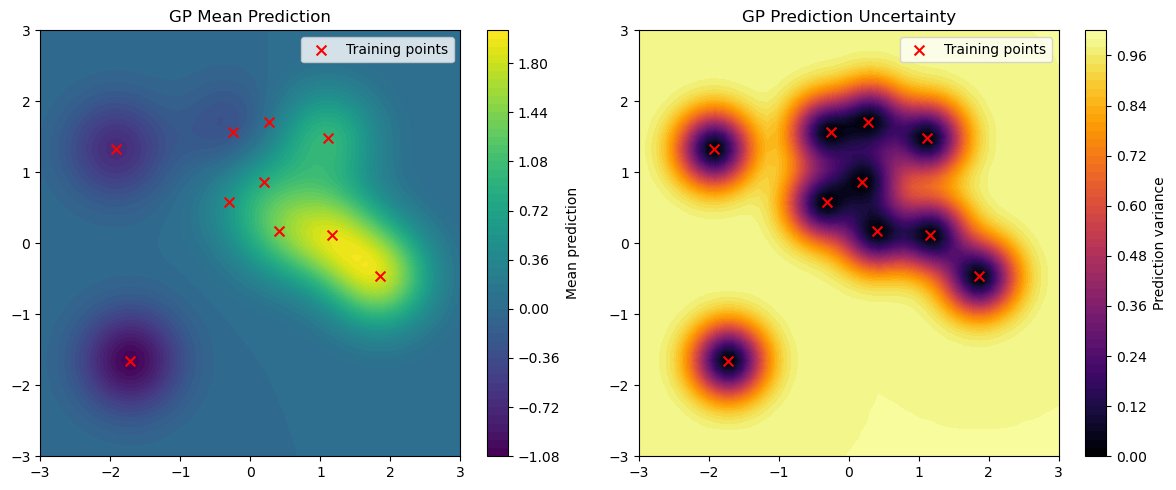

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def rbf_kernel(X1, X2, l=1.0, sigma_f=1.0):
    """RBF kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def gaussian_process(X_train, y_train, X_test, noise_var=1e-8, l=1.0, sigma_f=1.0):
    """Gaussian Process regression"""
    K = rbf_kernel(X_train, X_train, l, sigma_f) + noise_var * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_test, l, sigma_f)
    K_ss = rbf_kernel(X_test, X_test, l, sigma_f) + 1e-8 * np.eye(len(X_test))
    
    K_inv = np.linalg.inv(K)
    
    # Posterior mean
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    
    # Posterior variance
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, np.diag(cov_s)

def gaussian_process_cov(X_train, X_test, noise_var=1e-8, l=1.0, sigma_f=1.0):
    """Gaussian Process regression"""
    K = rbf_kernel(X_train, X_train, l, sigma_f) + noise_var * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_test, l, sigma_f)
    K_ss = rbf_kernel(X_test, X_test, l, sigma_f) + 1e-8 * np.eye(len(X_test))
    
    K_inv = np.linalg.inv(K)
    
    # Posterior variance
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return np.diag(cov_s)

# Generate some sample data
np.random.seed(0)
X_train = np.random.rand(10, 2) * 4 - 2  # 10 random points in [-2, 2] x [-2, 2]
y_train = np.sin(X_train[:, 0]) + np.cos(X_train[:, 1])  # Some arbitrary function

# Create a grid of test points
x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
X_test = np.vstack((X.ravel(), Y.ravel())).T

# Perform GP regression
mu_s, var_s = gaussian_process(X_train, y_train, X_test, l=0.5, sigma_f=1.0)

# Plot the results
plt.figure(figsize=(12, 5))

# Mean prediction
plt.subplot(121)
plt.contourf(X, Y, mu_s.reshape(X.shape), levels=50, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', marker='x', s=50, label='Training points')
plt.title('GP Mean Prediction')
plt.legend()

# Uncertainty (variance)
plt.subplot(122)
plt.contourf(X, Y, var_s.reshape(X.shape), levels=50, cmap='inferno')
plt.colorbar(label='Prediction variance')
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', marker='x', s=50, label='Training points')
plt.title('GP Prediction Uncertainty')
plt.legend()

plt.tight_layout()
plt.show()

$ \sigma \times \nabla f$

data -> NN predicting ERD -> acquisition function -> sample -> data -> loop

RD is $\sum_{pixels} (idw(old_\text{data}) - Truth) - (idw(old_\text{data} + new_\text{data}) - Truth) = \sum_{pixels} idw(old) - idw(old + new) = \int_{pixels} idw(old) - idw(old + new)$

Find top K ERD points -> coordinates -> Google-OR to TSP -> scan path connecting step scan points

> Naive conversion to convert to fly-scan, scan along suggested paths from the step scan FAST suggestion. FAST only cares about
> start and end of the path.

Objective function is $\int_\Omega ERD(x;\text{new data}_{\{i\} + \{j\}}) dx - \int_\Omega ERD(x;\text{data}_i) dx$

Can we add an "exclustion zone" to selected points? This will help us avoid "hovering" where the max ERD value is selected and the probe doesn't move

> Optimal free path is to just continuously acquire at the max ERD point

TODO
* What is the FAST paper doing with ERD?
* How can we avoid solutions that just acquire a single point?
* How can we define an objective function gradient?
* SLADS paper for acquisition function understanding (FAST is just approximating this with a NN)

Constriants
* Length of the path (cannot be infinite length path); find the path with a fixed length that maximizes the ERD
* Path does not need to be sequences of straight lines? Path can be curved
    * Search within some fixed distance from the current probe position for ERD maximizing path (some circle around the current probe pos.)
    * Constraints on how the stage can move

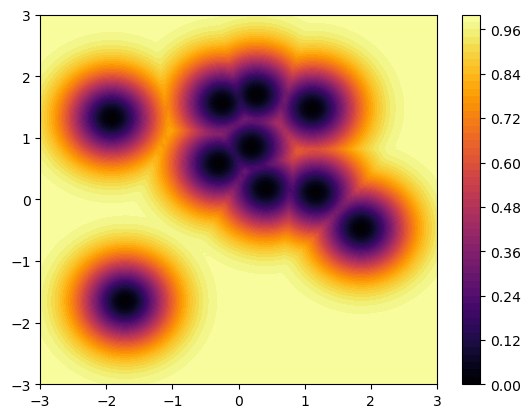

In [22]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
# X_train = np.vstack(
X,Y = np.meshgrid(x,y)
Z = kernel_func_2(np.vstack((X.reshape((-1,)), Y.reshape((-1,)))).T, X_train, sigma=1, length=0.5).reshape(X.shape)
plt.figure()
# plt.imshow(Z)
plt.contourf(X, Y, Z, levels=50, cmap='inferno')
plt.colorbar()

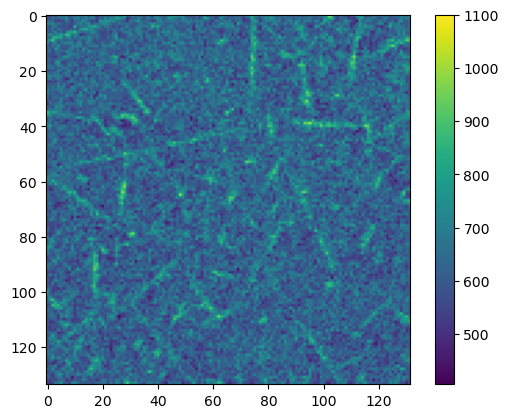

In [24]:
plt.figure()
plt.imshow(image)
plt.colorbar()

# Use source code

In [25]:
import os
import tifffile
from autobl.steering import configs
from autobl.steering import measurement
from autobl import image_proc

image = tifffile.imread(os.path.join("tests","data", "xrf", "xrf_2idd_Cs_L.tiff"))

probe = None

sample_params = configs.SpatialSampleParams(image=image, psize_nm=1.0)
setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,
    scan_speed_nm_sec=1.0,
    exposure_sec=0.8,
    deadtime_sec=0.8,
    probe=probe,
)
measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,
    setup_params=setup_params,
    step_size_for_integration_nm=0.02,
)

measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(
    measurement_configs
)

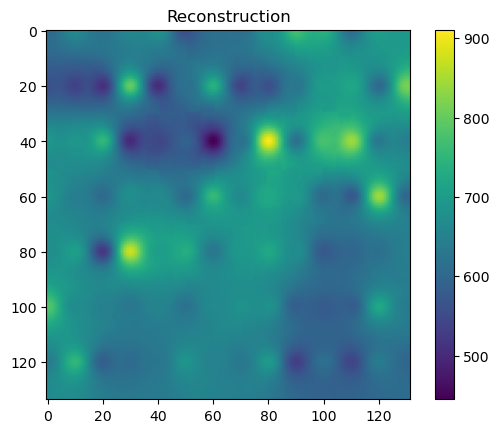

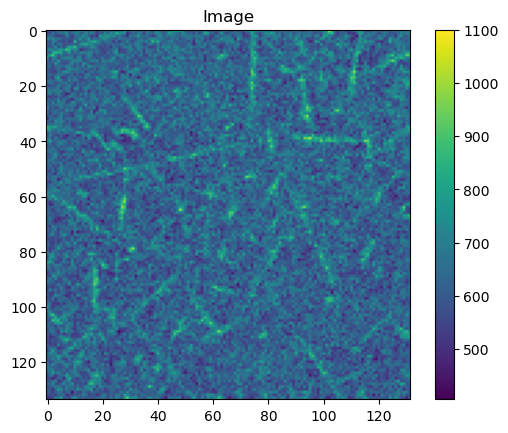

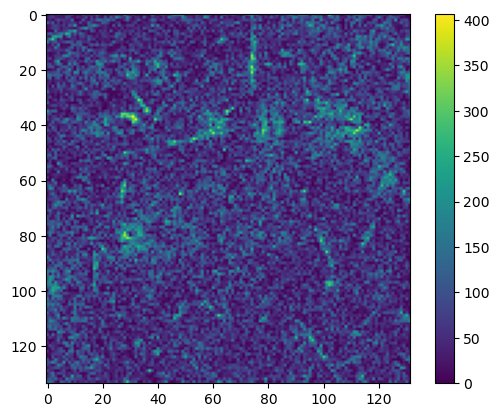

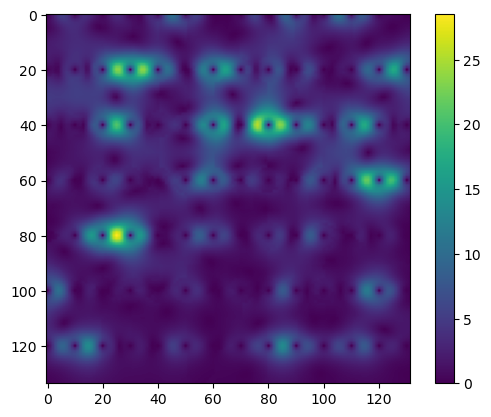

In [26]:
reconstructor = image_proc.Reconstructor("idw", backend="torch")
points = np.array([[0.,0.],[0.,1.],[1.,1.], [0.5, 0.5], [0.4, 0.5],[0.45, 0.5], [0.7, 0.3], [0.1, 0.9]])
y = np.arange(0, image.shape[0], 20.)
x = np.arange(0, image.shape[1], 10)

meshgrids = np.meshgrid(y, x, indexing='ij')
points = np.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))

values = measurement_interface.get_interpolated_values_from_image(points)
# # plt.figure()
# # plt.imshow(values.reshape(meshgrids[0].shape) - image)
# # # plt.imshow(Z - image)
# # plt.colorbar()

x = np.arange(0, image.shape[0], 1.)
y = np.arange(0, image.shape[1], 1.)
meshgrids = np.meshgrid(x, y, indexing='ij')
sample_points = np.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))

recon = reconstructor.reconstruct(points, values, meshgrids=np.meshgrid(x, y, indexing='ij'), n_neighbors = 9)

recon_grad = reconstructor.reconstruct_idw_grad(points, values, meshgrids=np.meshgrid(x, y, indexing='ij'), n_neighbors = 9)
# recon = idw(points, values, np.vstack((meshgrids[0].reshape((-1,)), meshgrids[1].reshape((-1,)))).T).reshape(meshgrids[0].shape)


plt.figure()
plt.title("Reconstruction")
plt.imshow(recon)
# plt.scatter(points[:,0], points[:,1])
plt.colorbar()

plt.figure()
plt.title("Image")
plt.imshow(image)
# plt.imshow(measurement_interface.probe_image - image)
plt.colorbar()

plt.figure()
plt.imshow(np.abs(torch.tensor(image) - recon))
plt.colorbar()

plt.figure()
plt.imshow(np.linalg.norm(recon_grad, axis = 0))
plt.colorbar()

# Strategy
Make entire acquisition function in pytorch

Points and values from current knowledge

Points and values from pseudo measurements (fixed values, do not include): We want gradients of th eAcquisition function w.r.t. these positions

## Pseudo code:
```python
N_neighbors = ...
x = torch.linspace(...)
y = torch.linspace(...)
xi = torch.meshgrid(y,x, ordering='ij')

recon_current = reconstruction(points_current, values_current, xi, ...)

points_scan = torch.tensor(..., requires_grad = True)
values = torch.tensor(..., requires_grad = False)  # If we want this to vary w.r.t. the reconstruction, more complicated, but doable I think...

points = torch.concatenate((points_current, points_scan))  # May need a [--x--,--y--] flat tensor of scan
values = torch.concatenate((values_current, pseudo_values_scan))

nn_inds = nearest_neighbors(points, xi, N_neighbors)
# We can filter nn_inds to remove any rows that don't have indices w.r.t. the scan points (gradient does not depend on these) 
# That filter is for nn_inds and for the points and xi values (the rest of the information can be safely ignored)

def acquisition_func(points, values, recon_current, xi, nn_inds):
    # pseudo_recon = reconstruction(points, values, xi, nn_inds)  # Nearest neighbors 
    pseudo_recon_grad_norm = torch.norm(reconstruction_grad(points, values, xi, nn_inds), axis=-1)
    rbf_uncertainty = rbf(points, xi, sigma, nn_inds)
    return pseudo_recon_grad * rbf_uncertainty

def rbf_uncertainty(points, xi, sigma, nn_inds):
    # some rbf uncertainty measure

total_uncertainty = torch.sum(acquisition_func(points, values, recon_current, xi, nn_inds))

total_uncertainty.backward()
points_scan.grad
```

This is the gradient of the some kind of uncertainty (we want to reduce the uncertainty).

This does not enforce constraints. We can pass this gradient to IPOPT to use with constraints.
Or we can do an unconstrained approach to get optimal raster scan locations (different approach than the FAST paper).



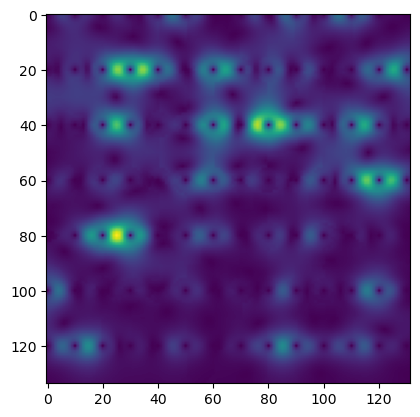

In [27]:
from typing import Tuple

def reconstruct_idw_grad_torch(
    points: torch.Tensor,
    values: torch.Tensor,
    meshgrids: Tuple[torch.Tensor, torch.Tensor] = None,
    xi: torch.tensor = None,
    n_neighbors: int = None,
    power: float = 2.0,
    epsilon: float = 1e-7,
):
    """
    Inverse distance weighted interpolation gradient with nearest neighbors (pytorch implementation)

    :param points: torch.Tensor. points to interpolate between, shape (num
        interp points, dimension)
    :param values: torch.Tensor. values to interpolate between, shape (num
        interp points,)
    :param meshgrids: Tuple[torch.Tensor, torch.Tensor]. grid to get
        interpolated values for
    :param xi: torch.Tensor. points to measure at
    :param n_neighbors: number of nearest neighbors to use in the
        reconstruction
    """
    if meshgrids is not None:
        xi = torch.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))
    if n_neighbors is None:
        n_neighbors = 4
    if n_neighbors == -1:
        n_neighbors = len(points)
    knn_engine = NearestNeighbors(n_neighbors=n_neighbors)
    knn_engine.fit(points.detach().numpy())

    # Find nearest measured points for each queried point.
    nn_inds = knn_engine.kneighbors(xi.detach().numpy(), return_distance= False)
    nn_dists = torch.sqrt(
        torch.sum((xi[:,None,:] - points[nn_inds]) ** 2, dim=-1)
    )
    values = values[torch.tensor(nn_inds)]

    inv_distances = 1 / (nn_dists + epsilon)
    sum_inv_distances = torch.sum(inv_distances**power, axis=1)

    inv_cubed = inv_distances ** (power + 2)
    sum_val_inv_distances = torch.sum(values * (inv_distances**power), axis=1)
    val_inv_cubed = values * inv_distances ** (power + 2)
    diff_x = xi[:, None, 0] - points[nn_inds, 0]
    diff_y = xi[:, None, 1] - points[nn_inds, 1]

    dx = (
        (
            -sum_inv_distances * torch.sum(val_inv_cubed * diff_x, axis=1)
            + sum_val_inv_distances * torch.sum(inv_cubed * diff_x, axis=1)
        )
        / (sum_inv_distances**2)
    )

    dy = (
        (
            -sum_inv_distances * torch.sum(val_inv_cubed * diff_y, axis=1)
            + sum_val_inv_distances * torch.sum(inv_cubed * diff_y, axis=1)
        )
        / (sum_inv_distances**2)
    )

    return torch.stack((dx,dy),dim=0)
y_dense = torch.arange(0.0, image.shape[0], 1)
x_dense = torch.arange(0.0, image.shape[1], 1)
meshgrids_dense = torch.meshgrid(y_dense,x_dense, indexing='ij')
xi = torch.stack(meshgrids_dense, dim=-1).reshape(-1, len(meshgrids_dense))
# xi_ = torch.stack((xi[0].reshape(-1), xi[1].reshape(-1)), axis = 1)
plt.figure()
plt.imshow(torch.linalg.norm(reconstruct_idw_grad_torch(torch.tensor(points), torch.tensor(values), xi = xi, n_neighbors=9), axis = 0).reshape(meshgrids_dense[0].shape))

  0%|          | 0/1 [00:00<?, ?it/s]

distortion unoptimized: 4923313.16041288


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'probe_image')

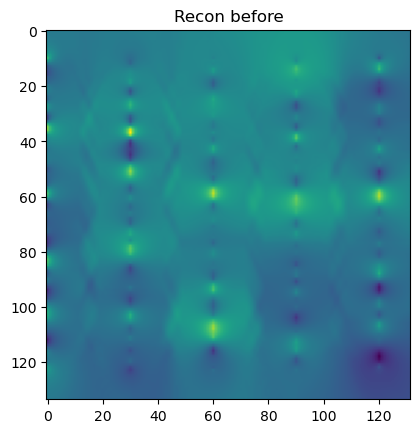

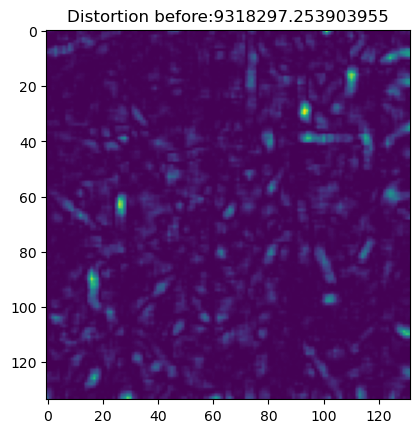

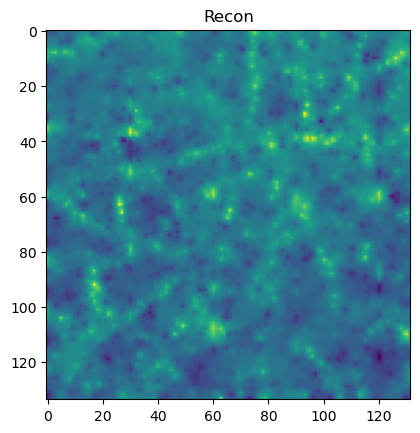

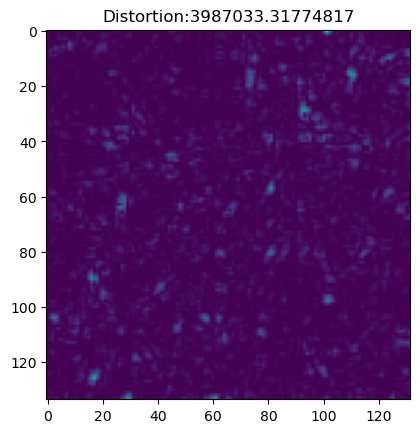

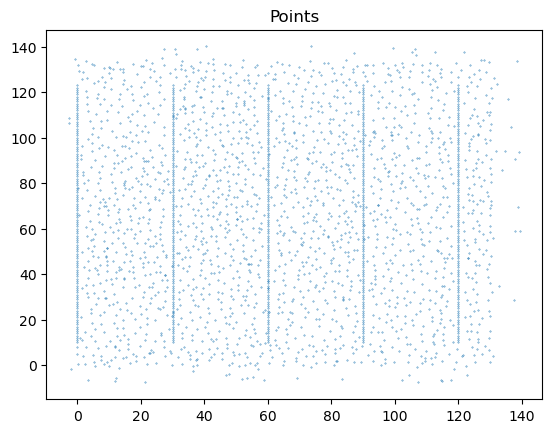

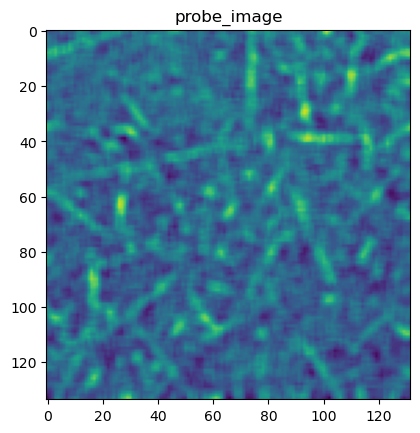

In [40]:
from sklearn.neighbors import NearestNeighbors
import torch.optim as optim
from tqdm.notebook import tqdm, trange


image = tifffile.imread(os.path.join("tests","data", "xrf", "xrf_2idd_Cs_L.tiff"))

probe = np.ones((4,4))

sample_params = configs.SpatialSampleParams(image=image, psize_nm=1.0)
setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,
    scan_speed_nm_sec=1.0,
    exposure_sec=0.8,
    deadtime_sec=0.8,
    probe=probe,
)
measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,
    setup_params=setup_params,
    step_size_for_integration_nm=0.02,
)

measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(
    measurement_configs
)

reconstructor = image_proc.Reconstructor("idw", backend="torch")
reconstruction = reconstructor.reconstruct_idw_torch

def distortion(image, recon):
    return 0.5*(image - recon)**2

N_neighbors = 30
N_neighbors_current = 30
N_neighbors_scan = 30

power = 2

# Dense reconstruction points
y_dense = torch.arange(0.0, image.shape[0], 1)
x_dense = torch.arange(0.0, image.shape[1], 1)
meshgrids_dense = torch.meshgrid(y_dense,x_dense, indexing='ij')
xi = torch.stack(meshgrids_dense, dim=-1).reshape(-1, len(meshgrids_dense))  # flatten meshgrids

# Current points and values
y_current = torch.arange(10, image.shape[0]-10, 1)
x_current = torch.arange(0, image.shape[1], 30)
meshgrids_current = torch.meshgrid(y_current, x_current, indexing='ij')
points_current = torch.stack(meshgrids_current, axis=-1).reshape(-1, len(meshgrids_current))
for j in trange(1):
    values_current = torch.tensor(measurement_interface.get_interpolated_values_from_image(points_current))
    probe_image = measurement_interface.probe_image
    
    recon_current = reconstructor.reconstruct_idw_torch(points_current, values_current, xi = xi, n_neighbors=N_neighbors, power = power)
    plt.figure()
    plt.imshow(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape))
    plt.title("Recon before")
    plt.figure()
    plt.imshow(distortion(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image))
    plt.title(f"Distortion before:{np.sum(distortion(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image))}")

    # points_scan = np.stack((np.linspace(10.01,100.01, 50), np.linspace(10.01,110.01, 50)), axis = -1)
    points_scan = np.stack((np.random.uniform(2, image.shape[0] - 2, size = (2000,)), np.random.uniform(2, image.shape[1] - 2, size = (2000,))), axis = -1)
    points_scan = torch.tensor(points_scan, requires_grad = True)

    points = torch.concatenate((points_current, points_scan))  # May need a [--x--,--y--] flat tensor of scan?
    knn_engine = NearestNeighbors(n_neighbors=N_neighbors)
    knn_engine.fit(points.detach().numpy())
    nn_inds = knn_engine.kneighbors(xi, return_distance=False)
    pseudo_values = torch.tensor(measurement_interface.get_interpolated_values_from_image(points.detach().numpy()))
    pseudo_recon = reconstructor.reconstruct_idw_torch(points, pseudo_values, xi=xi, nn_inds = nn_inds, power = power)
    # plt.figure()
    # plt.imshow(pseudo_recon.detach().numpy().reshape(meshgrids_dense[0].shape))
    # plt.scatter(points.detach().numpy()[:,1], points.detach().numpy()[:,0], s = 0.1)
    print(f"distortion unoptimized: {np.sum(distortion(pseudo_recon.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image)):8.8f}", end='\n')
    
    optimizer = optim.Adam((points_scan,), lr=0.01)
    
    for i in trange(1000):
        # points_scan = points_scan.clone().detach().requires_grad_(True)
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(points_current, values_current, xi = points_scan, n_neighbors=N_neighbors, power=power)
        # If we want this to vary w.r.t. the reconstruction, more complicated, but doable I think...
        
        points = torch.concatenate((points_current, points_scan))  # May need a [--x--,--y--] flat tensor of scan?
        values = torch.concatenate((values_current, pseudo_values_scan))
        
        knn_engine = NearestNeighbors(n_neighbors=N_neighbors)
        knn_engine.fit(points.detach().numpy())
        nn_inds = knn_engine.kneighbors(xi, return_distance=False)
    
        knn_engine_current = NearestNeighbors(n_neighbors=N_neighbors_current)
        knn_engine_current.fit(points_current.detach().numpy())
        nn_inds_current = knn_engine_current.kneighbors(xi, return_distance=False)
    
        knn_engine_scan = NearestNeighbors(n_neighbors=N_neighbors_current)
        knn_engine_scan.fit(points_scan.detach().numpy())
        nn_inds_scan = knn_engine_scan.kneighbors(xi, return_distance=False)
    
        nn_inds_concat = np.concatenate((nn_inds_current, nn_inds_scan), axis = 1)
        
        
        # We can filter nn_inds to remove any rows that don't have indices w.r.t. the scan points (gradient does not depend on these) 
        # That filter is for nn_inds and for the points and xi values (the rest of the information can be safely ignored)
        
        def acquisition_func(points, values, recon_current, xi, nn_inds, sigma:float = 1.0):
            pseudo_recon = reconstructor.reconstruct_idw_torch(points, values, xi=xi, nn_inds = nn_inds_current, power = power)  # Nearest neighbors
            grad = reconstructor.reconstruct_idw_grad_torch(points, values, xi=xi, nn_inds = nn_inds_current, power = power)
            pseudo_recon_grad_norm = torch.linalg.norm(grad, axis=0)
            # plt.figure()
            # plt.imshow(pseudo_recon_grad_norm.detach().numpy().reshape(meshgrids_dense[0].shape))
            # rbf = rbf_uncertainty(points, xi, sigma, np.concatenate((nn_inds_current[:,0:], nn_inds_scan[:,0:]), axis = 1))
            max_rbf = rbf_uncertainty(points, xi, sigma, nn_inds)
            # plt.figure()
            # plt.imshow(rbf.detach().numpy().reshape(meshgrids_dense[0].shape))
            # return pseudo_recon_grad_norm * rbf
            return pseudo_recon * max_rbf

        def softmax(values):
            a = torch.exp(values)
            return a/(torch.sum(a, axis = -1, keepdims = True))
        
        def rbf_uncertainty(points, xi, sigma, nn_inds, length = 4.):
            # nn_dists = torch.sqrt(torch.sum((xi[:, None, :] - points[nn_inds]) ** 2, dim=-1))
            square_dists = torch.sum((xi[:, None, :] - points[nn_inds]) ** 2, dim=-1) / (length ** 2)
            out = sigma**2 * (1 - torch.exp(- torch.sum(softmax(-square_dists) * square_dists, axis = -1)))
            # plt.figure()
            # plt.imshow(out.detach().numpy().reshape(meshgrids_dense[0].shape))
            # plt.title("RBF")
            # # plt.figure()
            # # plt.figure()
            # # plt.imshow(torch.sum(square_dists, axis = -1).detach().numpy().reshape(meshgrids_dense[0].shape))
            # plt.colorbar()
            
            # return out
            # plt.figure()
            # plt.plot(nn_dists.detach().numpy())
            # w = sigma**2 * (1 - torch.exp(-torch.exp(torch.mean(torch.log(nn_dists[:,:1]), axis = 1))/length))
            out = sigma**2 * (1 - torch.exp(-square_dists[:,0]/length**2))
            # plt.plot(w.detach().numpy())
            # print(w.detach().numpy())
            # plt.figure()
            # plt.imshow(out.detach().numpy().reshape(meshgrids_dense[0].shape))
            # plt.title("RBF")
            # plt.colorbar()
            
            return out
        
        # plt.figure()
        # plt.imshow(acquisition_func(points, values, recon_current, xi, nn_inds).reshape(meshgrids_dense[0].shape).detach().numpy())
        # plt.scatter(points_scan.detach().numpy()[:,1], points_scan.detach().numpy()[:,0])
        # plt.title("Acq")

        acq = acquisition_func(points, values, recon_current, xi, nn_inds)
        pseudo_values = torch.tensor(measurement_interface.get_interpolated_values_from_image(points.detach().numpy()))
        pseudo_recon = reconstructor.reconstruct_idw_torch(points, pseudo_values, xi=xi, nn_inds = nn_inds, power = power)
        # plt.figure()
        # plt.imshow(pseudo_recon.detach().numpy().reshape(meshgrids_dense[0].shape))
        # plt.scatter(points.detach().numpy()[:,1], points.detach().numpy()[:,0], s = 0.1)
        total_uncertainty = torch.sum(acq)
        print(f"{i:8d}, uncertainty {total_uncertainty:8.8f}, distortion: {np.sum(distortion(pseudo_recon.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image)):8.8f}", end='\r')
        
        
        total_uncertainty.backward()
        # torch.sum(distortion(pseudo_recon, torch.tensor(probe_image).flatten())).backward()
        # print(points_scan.grad)
        # grad = points_scan.grad
        # step_size = 0.0001
        # points_scan.data = points_scan.data - step_size * points_scan.grad.data
        # zeroing gradients after each iteration
        # points_scan.grad.data.zero_()
        optimizer.step()
    
    # plt.figure()
    # plt.imshow(acq.reshape(meshgrids_dense[0].shape).detach().numpy())
    # plt.scatter(points_scan.detach().numpy()[:,1], points_scan.detach().numpy()[:,0])

    points_current = torch.concatenate((points_current, points_scan.detach()), axis = 0)


values_current = torch.tensor(measurement_interface.get_interpolated_values_from_image(points_current))

recon_current = reconstructor.reconstruct_idw_torch(points_current, values_current, xi = xi, n_neighbors=N_neighbors, power = power)
plt.figure()
plt.imshow(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape))
plt.title("Recon")
plt.figure()
plt.imshow(distortion(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image))
plt.title(f"Distortion:{np.sum(distortion(recon_current.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image))}")
plt.figure()
plt.scatter(points_current.detach().numpy()[:,1], points_current.detach().numpy()[:,0], s = 0.1)
plt.title("Points")

plt.figure()
plt.imshow(probe_image)
plt.title("probe_image")

# x = torch.arange(0, image.shape[0], 1)
# y = torch.arange(0, image.shape[1], 1)
# meshgrids = torch.meshgrid(x, y, indexing='ij')
# sample_points = torch.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))

# recon = reconstructor.reconstruct(points, values, meshgrids=meshgrids, n_neighbors = 9)
# # recon_grad = reconstructor.reconstruct_idw_grad(points, values, meshgrids=np.meshgrid(x, y, indexing='ij'), n_neighbors = 9)
# # recon = idw(points, values, np.vstack((meshgrids[0].reshape((-1,)), meshgrids[1].reshape((-1,)))).T).reshape(meshgrids[0].shape)


# plt.figure()
# plt.title("Reconstruction")
# plt.imshow(recon)
# # plt.scatter(points[:,0], points[:,1])
# plt.colorbar()

# plt.figure()
# plt.title("Image")
# plt.imshow(image)
# # plt.imshow(measurement_interface.probe_image - image)
# plt.colorbar()

# plt.figure()
# plt.imshow(np.abs(torch.tensor(image) - recon))
# plt.colorbar()

# plt.figure()
# plt.imshow(np.linalg.norm(recon_grad, axis = 0))
# plt.colorbar()

In [29]:
(2000 + (14*image.shape[0]))/(image.shape[0]*image.shape[1])

0.21913161465400272

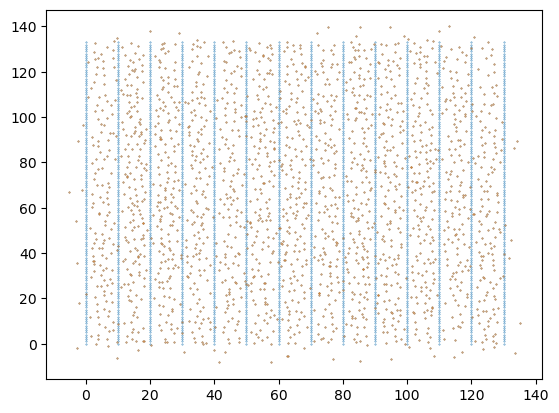

In [30]:
plt.figure()
plt.scatter(points_current.detach().numpy()[:,1], points_current.detach().numpy()[:,0], s = 0.1)
plt.scatter(points_scan.detach().numpy()[:,1], points_scan.detach().numpy()[:,0], s = 0.1)

In [31]:
points = torch.tensor([[0,0],[0,1],[1,1], [0.5, 0.5], [0.4, 0.5],[0.45, 0.5], [0.7, 0.3], [0.1, 0.9]], requires_grad=True)
y = torch.arange(0.0, image.shape[0], 20, requires_grad = True)
x = torch.arange(0.0, image.shape[1], 10, requires_grad = True)
values = torch.tensor(values, requires_grad=True)
xi = torch.meshgrid(x, y, indexing='ij')
xi[0].retain_grad()
recon = reconstructor.reconstruct(points, values, meshgrids=xi, n_neighbors = 4)
recon[0,0].backward()

xi[0].grad

/var/folders/2x/457yjlyd2d19zw63k2w544p00000gq/T/ipykernel_96836/1322260699.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values, requires_grad=True)


tensor([[nan, 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [32]:
rbf_kernel(points.detach().numpy(), sample_points).shape

(8, 17688)

## Using the full gaussian process is really costly

In this case, we use just the uncertainty from the GP and ignore the mean function. I'm not even sure that makes sense.

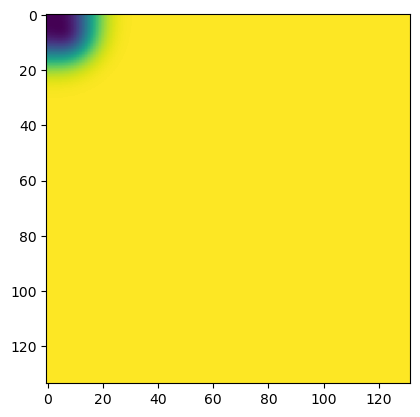

In [33]:
plt.imshow(gaussian_process_cov(points.detach().numpy(), sample_points, l=10, sigma_f=5).reshape(meshgrids[0].shape))

## Approximate the uncertainty using RBF
We want to get uncertainty at locations using an RBF

We then want to get the gradient of the acquisition function, $\nabla (\|\nabla g\| \sigma(g))$

In [34]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 4
knn_engine = NearestNeighbors(n_neighbors=n_neighbors)
knn_engine.fit(points.detach().numpy())
queried_points = np.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))
nn_dists, nn_inds = knn_engine.kneighbors(queried_points, return_distance=True)

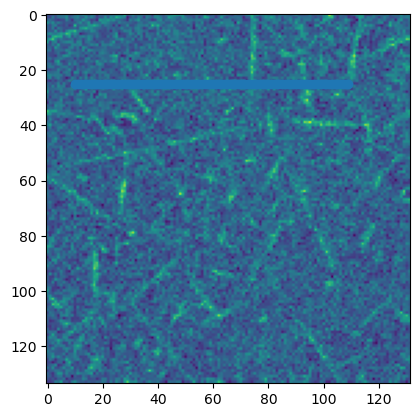

In [35]:
x = np.arange(10, 110, 1)
y = 25*np.ones(x.shape)
new_points = np.stack((x,y), axis= -1,)
plt.figure()
plt.imshow(image)
plt.scatter(new_points[:,0], new_points[:,1])

Text(0.5, 1.0, 'gradient norm')

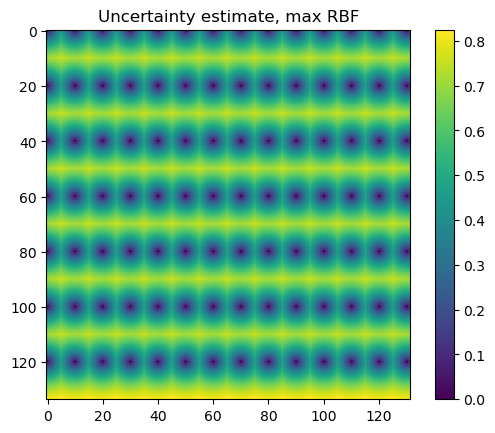

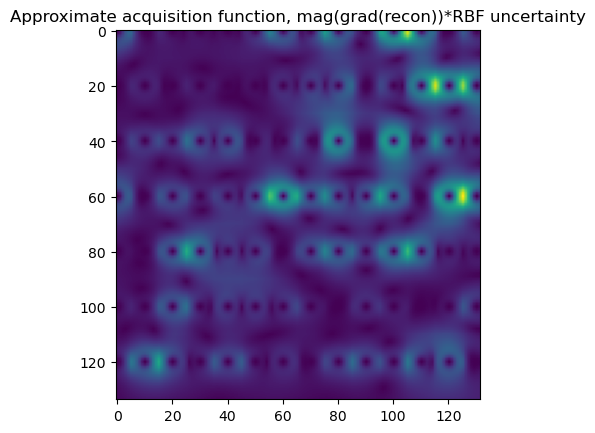

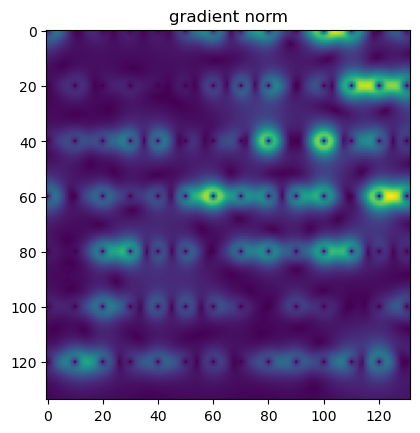

In [36]:
points = np.array([[0,0],[0,1],[1,1], [0.5, 0.5], [0.4, 0.5],[0.45, 0.5], [0.7, 0.3], [0.1, 0.9]])
y = np.arange(0, image.shape[0], 20)
x = np.arange(0, image.shape[1], 10)

meshgrids = np.meshgrid(y, x, indexing='ij')
points = np.stack(meshgrids, axis=-1).reshape(-1, len(meshgrids))

values = measurement_interface.get_interpolated_values_from_image(points)

def rbf_kernel(X1, X2, l=1.0, sigma_f=1.0):
    """RBF kernel"""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def rbf_uncertainty(points, xi, n_neighbors = 4, sigma_f = 1.0, l = 1.0):
    if n_neighbors > 0:
        knn_engine = NearestNeighbors(n_neighbors=n_neighbors)
        knn_engine.fit(points)
        nn_dists, nn_inds = knn_engine.kneighbors(xi, return_distance=True)
    else:
        nn_dists = cdist(xi, points)
    return np.min(sigma_f**2 * (1 - np.exp(-0.5 / l**2 * nn_dists)), axis = -1)


recon_x = np.arange(0, image.shape[0], 1)
recon_y = np.arange(0, image.shape[1], 1)
recon_meshgrids = np.meshgrid(recon_x, recon_y, indexing='ij')
recon_points = np.stack(recon_meshgrids, axis=-1).reshape(-1, len(recon_meshgrids))

reconstructor = image_proc.Reconstructor("idw")

n_neighbors = -1
recon = reconstructor.reconstruct(points, values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)
recon_grad = reconstructor.reconstruct_idw_grad(points, values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)

unc = rbf_uncertainty(points, recon_points, l = 2.0, n_neighbors=n_neighbors).reshape(recon_meshgrids[0].shape)
plt.figure()
plt.imshow(unc)
plt.title("Uncertainty estimate, max RBF")
plt.colorbar()

plt.figure()
plt.imshow(np.linalg.norm(recon_grad, axis = 0) * unc)
plt.title("Approximate acquisition function, mag(grad(recon))*RBF uncertainty")

plt.figure()
plt.imshow(np.linalg.norm(recon_grad,axis = 0))
plt.title("gradient norm")

Value of each pixel is the acquistion function value.

We want the value over the whole image if we add a new point.

We also want the gradient of that improved value due to adding that new point.

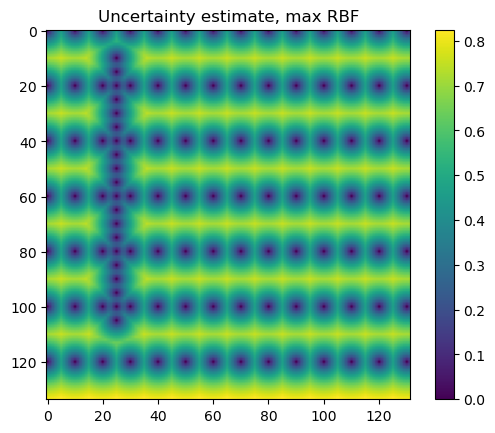

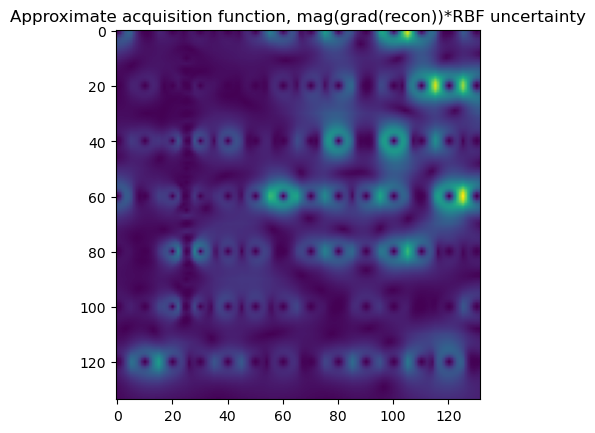

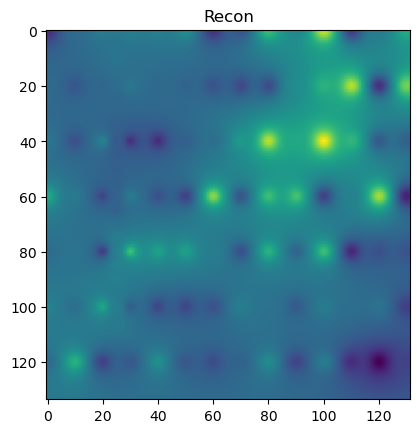

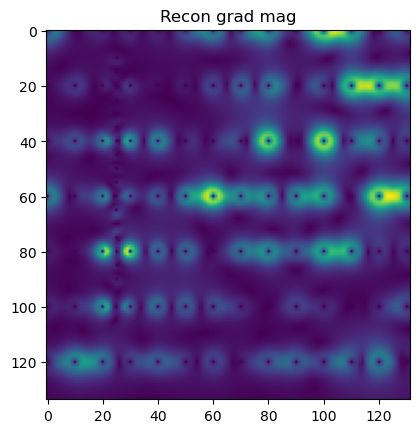

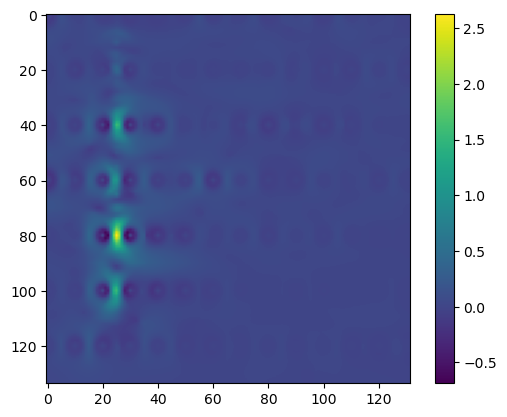

In [37]:
n_neighbors = -1

x = np.arange(10, 110, 5)
y = 25*np.ones(x.shape)
new_points = np.stack((x,y), axis= -1,)

extended_points = np.concatenate((points, new_points), axis = 0)
new_values = reconstructor.reconstruct(points, values, xi = new_points)
extended_values = np.concatenate((values, new_values), axis = 0)

recon = reconstructor.reconstruct(extended_points, extended_values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)
recon_grad = reconstructor.reconstruct_idw_grad(extended_points, extended_values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)

unc = rbf_uncertainty(extended_points, sample_points, l = 2.0, n_neighbors=n_neighbors).reshape(recon_meshgrids[0].shape)
plt.figure()
plt.imshow(unc)
plt.title("Uncertainty estimate, max RBF")
plt.colorbar()

plt.figure()
plt.imshow(np.linalg.norm(recon_grad, axis = 0) * unc)
plt.title("Approximate acquisition function, mag(grad(recon))*RBF uncertainty")

plt.figure()
plt.imshow(recon)
plt.title("Recon")
plt.figure()
plt.imshow(np.linalg.norm(recon_grad, axis = 0))
plt.title("Recon grad mag")

def objective(points, new_points, n_neighbors:int = 4):
    values = measurement_interface.get_interpolated_values_from_image(points)
    extended_points = np.concatenate((points, new_points), axis = 0)
    new_values = reconstructor.reconstruct(points, values, xi = new_points)
    extended_values = np.concatenate((values, new_values), axis = 0)

    recon_x = np.arange(0, image.shape[0], 1)
    recon_y = np.arange(0, image.shape[1], 1)
    recon_meshgrids = np.meshgrid(recon_x, recon_y, indexing='ij')
    recon_points = np.stack(recon_meshgrids, axis=-1).reshape(-1, len(recon_meshgrids))
    recon_grad = reconstructor.reconstruct_idw_grad(points, values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)
    recon_grad_extended = reconstructor.reconstruct_idw_grad(extended_points, extended_values, meshgrids=recon_meshgrids, n_neighbors = n_neighbors)
    
    unc = rbf_uncertainty(points, recon_points, l = 2.0, n_neighbors=n_neighbors).reshape(recon_meshgrids[0].shape)
    unc_extended = rbf_uncertainty(extended_points, recon_points, l = 2.0, n_neighbors=n_neighbors).reshape(recon_meshgrids[0].shape)

    return np.linalg.norm(recon_grad, axis = 0) * unc - np.linalg.norm(recon_grad_extended, axis = 0) * unc_extended
    # D(old) - D(old + new)
    # D(old + new)

plt.figure()
plt.imshow(objective(points, new_points, n_neighbors = n_neighbors))
plt.colorbar()

Use random grid for initial measurements. Allows for better estimates for length parameter of RBF.

Random can provide better initialization to estimate length scale.

## Gradient of objective function?

Doing finite differences is possible, but costly. Currently requires a full reconstruction, which should not be necessary since everything is using the nearest neighbors approach. Regions that are far from any nearest neighbors are basically just zero.

Objective is sum of acq_after - acq_before

So derivative with respect to new points is:
$$
\begin{align}
\frac{d}{d p_n} \int_\Omega f(x;p + p_n) - f(x;p) dx & = \int_\Omega (\frac{d}{d p_n} f(x;p+p_n)) - (\frac{d}{d p_n}  f(x;p)) dx\\
& = \int_\Omega (\frac{d}{d p_n} f(x;p+p_n)) dx
\end{align}
$$

Where $f(x ; p) = \|\nabla \mathcal{J}(x, p)\| RBF(p;x) |_x$

In [38]:
grid_t = np.linspace(0, 1, points_scan.shape[0])
obj = Objective(grid_t, points_current, power=2.0, N_neighbors=4, xi=xi)
x0 = np.concatenate((points_scan.flatten().detach().numpy(), np.zeros((points_scan.shape[0]*5,))))
# obj.solve(x0)
# obj.acq_objective(x0).detach().numpy()
# obj.acq_objective_grad(x0).detach().numpy()

def acq_objective_grad(combined_vars):
    (x, y, _theta, _v, _acc, _omega, _omega_acc) = obj.var_splitter(combined_vars)
    
    points_scan = torch.tensor(np.stack((x, y), axis=-1), requires_grad=True, dtype=torch.float64)

    points = torch.cat((points_current, points_scan))
    
    with torch.no_grad():
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(points_current, values_current, xi=points_scan, n_neighbors=N_neighbors, power=power)
    values = torch.cat((values_current, pseudo_values_scan))
    
    knn_engine = NearestNeighbors(n_neighbors=N_neighbors)
    knn_engine.fit(points.detach().cpu().numpy())
    nn_inds = knn_engine.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    knn_engine_current = NearestNeighbors(n_neighbors=N_neighbors_current)
    knn_engine_current.fit(points_current.detach().cpu().numpy())
    nn_inds_current = knn_engine_current.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    knn_engine_scan = NearestNeighbors(n_neighbors=N_neighbors_current)
    knn_engine_scan.fit(points_scan.detach().cpu().numpy())
    nn_inds_scan = knn_engine_scan.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    nn_inds_concat = np.concatenate((nn_inds_current, nn_inds_scan), axis=1)

    # Convert nn_inds back to PyTorch tensor if needed by acquisition_func
    nn_inds = torch.from_numpy(nn_inds).to(points.device)

    acq = acquisition_func(points, values, recon_current, xi, nn_inds)
    total_uncertainty = torch.sum(acq)
    print(total_uncertainty)

    # Make sure total_uncertainty is a scalar
    if total_uncertainty.numel() > 1:
        total_uncertainty = total_uncertainty.sum()

    # Clear previous gradients
    if points_scan.grad is not None:
        points_scan.grad.zero_()
    
    total_uncertainty.backward()
    grad = points_scan.grad.flatten().detach().cpu().numpy()

    return grad

acq_objective_grad(x0)

NameError: name 'Objective' is not defined

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
xi = xi.to(torch.float64)

def acq_objective_grad(combined_vars):
    (x, y, _theta, _v, _acc, _omega, _omega_acc) = obj.var_splitter(combined_vars)

    points_scan = torch.tensor(np.stack((x, y), axis=-1), requires_grad=True, dtype=torch.float64)
    points = torch.cat((points_current, points_scan))

    # Compute pseudo values using PyTorch operations
    with torch.no_grad():
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(points_current, values_current, xi=points_scan, n_neighbors=N_neighbors, power=power)
    values = torch.cat((values_current, pseudo_values_scan))

    # Use scikit-learn NearestNeighbors
    knn_engine = NearestNeighbors(n_neighbors=N_neighbors)
    knn_engine.fit(points.detach().cpu().numpy())
    nn_inds = knn_engine.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    knn_engine_current = NearestNeighbors(n_neighbors=N_neighbors_current)
    knn_engine_current.fit(points_current.detach().cpu().numpy())
    nn_inds_current = knn_engine_current.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    knn_engine_scan = NearestNeighbors(n_neighbors=N_neighbors_current)
    knn_engine_scan.fit(points_scan.detach().cpu().numpy())
    nn_inds_scan = knn_engine_scan.kneighbors(xi.detach().cpu().numpy(), return_distance=False)

    nn_inds_concat = np.concatenate((nn_inds_current, nn_inds_scan), axis=1)

    # Convert nn_inds back to PyTorch tensor if needed by acquisition_func
    # nn_inds = torch.from_numpy(nn_inds).to(points.device)

    acq = acquisition_func(points, values, recon_current, xi, nn_inds)
    total_uncertainty = torch.sum(acq)
    print(total_uncertainty)

    # Make sure total_uncertainty is a scalar
    if total_uncertainty.numel() > 1:
        total_uncertainty = total_uncertainty.sum()

    # Clear previous gradients
    if points_scan.grad is not None:
        points_scan.grad.zero_()

    total_uncertainty.backward()
    grad = points_scan.grad.flatten().detach().cpu().numpy()
    
    return grad

acq_objective_grad(x0)

In [ ]:
"""
Functions and optimization class to do the discretized DAE optimization
"""

import os
import pickle as pkl
import sys

from collections import namedtuple
from functools import cached_property
from typing import Dict

import cyipopt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

DAE_vars = namedtuple("DAE_vars", ["x", "y", "theta", "v", "acc", "omega", "omega_acc"])

FRAME_DIRECTORY = ".temp_frames"

jnp = np


class Objective(cyipopt.Problem):
    """Objective class to work with cyipopt"""

    def __init__(
        self,
        grid_t: np.ndarray,
        points_current: np.ndarray,
        xi = None,
        power:float = 2.0,
        N_neighbors: int = 2,
        **kwargs,
    ):
        self.power = power
        self.N_neighbors = N_neighbors
        self.N_neighbors_current = N_neighbors
        self.points_current = points_current
        self.xi = xi
        self.values_current = torch.tensor(measurement_interface.get_interpolated_values_from_image(self.points_current))
        self.recon_current = reconstructor.reconstruct_idw_torch(self.points_current, self.values_current, xi = self.xi, n_neighbors=self.N_neighbors, power = self.power)

        # Initial position
        self.enforce_initial_position = kwargs.get("enforce_initial_position", False)
        self.x0 = kwargs.get("x0", 0.7)
        self.y0 = kwargs.get("y0", 0.3)
        # Initial heading
        self.enforce_initial_heading = kwargs.get("enforce_initial_heading", False)
        self.theta0 = kwargs.get("theta0", np.pi / 2)

        # Final position
        self.enforce_final_position = kwargs.get("enforce_final_position", False)
        self.x_final = kwargs.get("x_final", 0.1)
        self.y_final = kwargs.get("y_final", 0.1)
        # Final heading
        self.theta_final = kwargs.get("theta_final", jnp.pi)

        self.periodic = kwargs.get("periodic", False)

        # Use the exact DAE (otherwise just use finite differences)
        self.use_exact_DAE = kwargs.get("use_exact_DAE", False)
        self.linear_tolerance = kwargs.get("linear_tolerance", 1e-3)

        # Build a video of the optimization process
        self.build_video = kwargs.get("build_video", False)
        if self.build_video:
            self.video_frames = {}

        self.NK = kwargs.get("NK", grid_t.shape[0])  # Number of control variables
        self.grid_t = grid_t  # Time grid
        self.T = kwargs.get("T", grid_t[-1] - grid_t[0])  # Total time
        self.h = self.T / self.NK  # Time grid spacing

        self.L = kwargs.get("L", 3.0)  # Maximum path length

        # Obstacles
        # # Centers
        # self.cxs = kwargs.get("cxs", [(0.5 + 0.25) / 2, (0.75 + 0.6) / 2])
        # self.cys = kwargs.get("cys", [(0.4 + 0.15) / 2, (0.85 + 0.6) / 2])
        # # Radii
        # self.rxs = kwargs.get("rxs", [(0.5 - 0.25) / 2, (0.75 - 0.6) / 2])
        # self.rys = kwargs.get("rys", [(0.4 - 0.15) / 2, (0.85 - 0.6) / 2])
        # Centers
        self.cxs = kwargs.get("cxs", [])
        self.cys = kwargs.get("cys", [])
        # Radii
        self.rxs = kwargs.get("rxs", [])
        self.rys = kwargs.get("rys", [])
        # Shape
        self.obstacle_shape = kwargs.get("obstacle_shape", "square")
        self.obstacle_buffer = kwargs.get("obstacle_buffer", 0.0)

        # Bound constraints
        # x
        self.x_lower = kwargs.get("x_lower", 0.0)
        self.x_upper = kwargs.get("x_upper", image.shape[1])
        # y
        self.y_lower = kwargs.get("y_lower", 0.0)
        self.y_upper = kwargs.get("y_upper", image.shape[0])
        # theta (unbounded)
        self.theta_lower = kwargs.get("theta_lower", -jnp.inf)
        self.theta_upper = kwargs.get("theta_upper", jnp.inf)
        # v
        self.v_lower = kwargs.get("v_lower", 0.0)
        self.v_upper = kwargs.get("v_upper", 3000.0)
        # acc
        self.acc_lower = kwargs.get("acc_lower", -1000.0)
        self.acc_upper = kwargs.get("acc_upper", 1000.0)
        # omega
        # self.omega_lower = kwargs.get("omega_lower", -jnp.pi / self.h)
        # self.omega_upper = kwargs.get("omega_upper", jnp.pi / self.h)
        self.omega_lower = kwargs.get("omega_lower", -jnp.inf)
        self.omega_upper = kwargs.get("omega_upper", jnp.inf)
        # omega_acc
        # self.omega_acc_lower = kwargs.get(
        #     "omega_acc_lower", -2.0 * jnp.pi / self.h / self.h
        # )
        # self.omega_acc_upper = kwargs.get(
        #     "omega_acc_upper", 2.0 * jnp.pi / self.h / self.h
        # )
        self.omega_acc_lower = kwargs.get("omega_acc_lower", -2.0 * jnp.inf)
        self.omega_acc_upper = kwargs.get("omega_acc_upper", 2.0 * jnp.inf)

        # Can limit the number of changes for acceleration to get piecewise constant controls
        # TODO - separate the time grid and control grid (grids should be aligned)
        self.piecewise_constant = kwargs.get("piecewise_constant", None)

        self.N_x = kwargs.get("N_x", self.NK)  # Number of x
        self.N_y = kwargs.get("N_y", self.NK)  # Number of y
        self.N_theta = kwargs.get("N_theta", self.NK)  # Number of theta
        self.N_v = kwargs.get("N_v", self.NK)  # Number of v
        self.N_acc = kwargs.get("N_acc", self.NK)  # Number of acc
        self.N_omega = kwargs.get("N_omega", self.NK)  # Number of omega
        self.N_omega_acc = kwargs.get("N_omega_acc", self.NK)  # Number of omega_acc

        self.reg_strength = kwargs.get("reg_strength", 0.000001)
        # Regularization strength

        self.x_shift = 0
        self.y_shift = self.x_shift + self.N_x
        self.theta_shift = self.y_shift + self.N_y
        self.v_shift = self.theta_shift + self.N_theta
        self.acc_shift = self.v_shift + self.N_v
        self.omega_shift = self.acc_shift + self.N_acc
        self.omega_acc_shift = self.omega_shift + self.N_omega

        self.var_lengths = DAE_vars(
            self.N_x,
            self.N_y,
            self.N_theta,
            self.N_v,
            self.N_acc,
            self.N_omega,
            self.N_omega_acc,
        )
        self.cum_var_lengths = DAE_vars(*tuple(jnp.cumsum(jnp.array(self.var_lengths))))
        self.indices = DAE_vars(
            *tuple(
                jnp.arange(cum_length - length, cum_length, 1, dtype=int)
                for cum_length, length in zip(self.cum_var_lengths, self.var_lengths)
            )
        )

        self.number_of_variables = (
            self.omega_acc_shift + self.N_omega_acc
        )  # number of variables

        # Initial condition
        initial_condition = kwargs.get("initial_condition", None)
        if initial_condition is not None:
            (x, y, theta, _v, _acc, _omega, _omega_acc) = self.var_splitter(
                initial_condition
            )
            self.x0 = x[0]
            self.y0 = y[0]
            self.x_final = x[-1]
            self.y_final = y[-1]
            self.theta0 = theta[0]
            self.theta_final = theta[-1]

        # Simplified two parameter mode
        self.circle_mode = kwargs.get("circle_mode", False)
        self.circle_center_x = kwargs.get("circle_center_x", 0.75 / 2)
        self.circle_center_y = kwargs.get("circle_center_y", 0.55 / 2)
        if self.circle_mode:
            self.enforce_final_position = False
            self.enforce_initial_position = False
            self.enforce_initial_heading = True
            self.acc_lower = 0.0
            self.acc_upper = 0.0
            self.omega_acc_lower = 0.0
            self.omega_acc_upper = 0.0

        self.num_equality_constraints = None
        self.num_inequality_constraints = None
        # Do an initialization of the constraints to get constraint numbers
        self.objective_value = 0.0
        self.constraints(jnp.ones((self.number_of_variables,)))
        super().__init__(
            n=self.number_of_variables,
            m=self.number_of_constraints,
            lb=self.lower_bounds,
            ub=self.upper_bounds,
            cl=self.constraint_lower_bounds,
            cu=self.constraint_upper_bounds,
        )

    def acq_objective(self, combined_vars):
        (x, y, _theta, _v, _acc, _omega, _omega_acc) = self.var_splitter(combined_vars)

        with torch.no_grad():
            points_scan = np.stack((x, y), axis = -1)
            points_scan = torch.tensor(points_scan, requires_grad = False)
            try:
                points_scan.grad.data.zero_()
            except:
                pass
        
            points = torch.concatenate((self.points_current, points_scan))  # May need a [--x--,--y--] flat tensor of scan?
            pseudo_values_scan = reconstructor.reconstruct_idw_torch(self.points_current, self.values_current, xi = points_scan, n_neighbors=self.N_neighbors, power=self.power)
            # If we want this to vary w.r.t. the reconstruction, more complicated, but doable I think...
        
            values = torch.concatenate((self.values_current, pseudo_values_scan))
            
            knn_engine = NearestNeighbors(n_neighbors=self.N_neighbors)
            knn_engine.fit(points.detach().numpy())
            nn_inds = knn_engine.kneighbors(self.xi, return_distance=False)
        
            knn_engine_current = NearestNeighbors(n_neighbors=self.N_neighbors_current)
            knn_engine_current.fit(points_current.detach().numpy())
            nn_inds_current = knn_engine_current.kneighbors(self.xi, return_distance=False)
        
            knn_engine_scan = NearestNeighbors(n_neighbors=self.N_neighbors_current)
            knn_engine_scan.fit(points_scan.detach().numpy())
            nn_inds_scan = knn_engine_scan.kneighbors(self.xi, return_distance=False)
        
            nn_inds_concat = np.concatenate((nn_inds_current, nn_inds_scan), axis = 1)
        
            acq = acquisition_func(points, values, self.recon_current, self.xi, nn_inds)
            total_uncertainty = torch.sum(acq)
            
            return total_uncertainty

    def acq_objective_grad(self, combined_vars):
        (x, y, _theta, _v, _acc, _omega, _omega_acc) = self.var_splitter(combined_vars)
        
        points_scan = np.stack((x, y), axis = -1)
        points_scan = torch.tensor(points_scan, requires_grad = True)
        try:
            points_scan.grad.data.zero_()
        except:
            pass
    
        points = torch.concatenate((self.points_current, points_scan))  # May need a [--x--,--y--] flat tensor of scan?
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(self.points_current, self.values_current, xi = points_scan, n_neighbors=self.N_neighbors, power=self.power)
        # If we want this to vary w.r.t. the reconstruction, more complicated, but doable I think...
    
        values = torch.concatenate((self.values_current, pseudo_values_scan))
        
        knn_engine = NearestNeighbors(n_neighbors=self.N_neighbors)
        knn_engine.fit(points.detach().numpy())
        nn_inds = knn_engine.kneighbors(self.xi, return_distance=False)
    
        knn_engine_current = NearestNeighbors(n_neighbors=self.N_neighbors_current)
        knn_engine_current.fit(points_current.detach().numpy())
        nn_inds_current = knn_engine_current.kneighbors(self.xi, return_distance=False)
    
        knn_engine_scan = NearestNeighbors(n_neighbors=self.N_neighbors_current)
        knn_engine_scan.fit(points_scan.detach().numpy())
        nn_inds_scan = knn_engine_scan.kneighbors(self.xi, return_distance=False)
    
        nn_inds_concat = np.concatenate((nn_inds_current, nn_inds_scan), axis = 1)
    
        acq = acquisition_func(points, values, self.recon_current, self.xi, nn_inds)
        total_uncertainty = torch.sum(acq)
        
        total_uncertainty.backward(retain_graph=True)
        grad = points_scan.grad.flatten().detach().numpy()  # Need to check that flatten in correct with this structure
        grad = np.concatenate((grad, np.zeros((grad.shape[0]//2*5,))))
        return grad
        
    def OED_objective(self, combined_vars: jnp.ndarray) -> float:
        """OED objective function"""
        return self.acq_objective(combined_vars)

    def OED_gradient(self, combined_vars: jnp.ndarray) -> jnp.ndarray:
        """Gradient of OED objective function"""
        return self.acq_objective_grad(combined_vars)

    def regularization_objective(self, combined_vars: jnp.ndarray) -> float:
        """Regularization objective function

        :param vars: jnp.ndarray. Combined variables
        :return: jnp.ndarray. Regularization objective value
        """
        (_x, _y, _theta, _v, acc, _omega, omega_acc) = self.var_splitter(combined_vars)
        # return (jnp.sum(v**2) + jnp.sum(omega**2))
        return jnp.sum(acc**2) + jnp.sum(omega_acc**2)
        # return jnp.sum(acc**2) + jnp.sum(2 - jnp.cos(omega * self.h))
        # return jnp.sum(acc**2) + jnp.sum(2 - jnp.cos(omega * self.h)) + jnp.sum(omega_acc ** 2)
        # return jnp.sum(acc**2) + jnp.sum(jnp.sin(omega * self.h)**2)
        # return jnp.sum(acc**2) + jnp.sum(jnp.sin(omega * self.h)**2) + jnp.sum(omega_acc ** 2)
        # return jnp.sum(acc**2) + jnp.sum(jnp.sin(omega_acc * self.h)**2) + jnp.sqrt(self.reg_strength) * jnp.sum(omega_acc**2)

    def regularization_gradient(self, combined_vars: jnp.ndarray):
        """Regularization objective function gradient

        :param vars: jnp.ndarray. Combined variables
        :return: jnp.ndarray. Gradient w.r.t. the regularization objective
        """
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(combined_vars)

        x = jnp.zeros(x.shape)
        y = jnp.zeros(y.shape)
        theta = jnp.zeros(theta.shape)
        v = jnp.zeros(v.shape)
        # v = 2*v
        # acc = jnp.zeros(acc.shape)
        acc = 2 * acc
        omega = jnp.zeros(omega.shape)
        # omega = self.h * jnp.sin(omega*self.h)
        # omega = 2 * self.h * jnp.sin(omega * self.h) * jnp.cos(omega * self.h)
        # omega = 2*omega
        # omega_acc = jnp.zeros(omega_acc.shape)
        omega_acc = 2 * omega_acc
        # omega_acc = 2 * self.h * jnp.sin(omega_acc * self.h) * jnp.cos(omega_acc * self.h) + 2 * jnp.sqrt(self.reg_strength) * omega_acc

        return self.var_joiner(x, y, theta, v, acc, omega, omega_acc)

    def objective(self, combined_vars: jnp.ndarray) -> float:
        """Objective function

        Combination of OED objective and regularization objective

        :param vars: jnp.ndarray. Combined variables
        :return: jnp.ndarray. Objective value
        """
        self.objective_value = self.OED_objective(
            combined_vars
        ) + self.reg_strength * self.regularization_objective(combined_vars)
        return self.objective_value

    def gradient(self, combined_vars: jnp.ndarray) -> jnp.ndarray:
        """Objective function gradient

        Combination of OED objective and regularization gradient

        :param vars: jnp.ndarray. Combined variables
        :return: jnp.ndarray. Gradient of objective w.r.t. variables
        """

        return self.OED_gradient(
            combined_vars
        ) + self.reg_strength * self.regularization_gradient(combined_vars)

    @property
    def number_of_constraints(self) -> int:
        """Number of constraints

        :return: int. Number of constraints
        """
        return self.num_equality_constraints + self.num_inequality_constraints

    def var_joiner(
        self,
        *args,
    ) -> jnp.ndarray:
        """Join variables into a single vector

        :param args: tuple[jnp.ndarray]. Variables to join
        :return: jnp.ndarray. Concatenated vector containing all of the DAE
            variables
        """
        return jnp.concatenate(args, axis=0)

    def var_splitter(self, combined_vars: jnp.ndarray) -> tuple[jnp.ndarray]:
        """Split variables from a single vector"""
        return DAE_vars(*tuple(jnp.split(combined_vars, self.cum_var_lengths[:-1])))

    @property
    def lower_bounds(self) -> jnp.ndarray:
        """Lower bounds on variables

        :return: jnp.ndarray. Vector of lower bounds on all discretized variables
        """
        x_lb = jnp.ones((self.N_x,)) * self.x_lower
        y_lb = jnp.ones((self.N_y,)) * self.y_lower
        theta_lb = jnp.ones((self.N_theta,)) * self.theta_lower
        v_lb = jnp.ones((self.N_v,)) * self.v_lower
        if self.piecewise_constant is not None:
            acc_lb = np.zeros((self.N_acc,))
            acc_lb[:: self.N_acc // self.piecewise_constant] = self.acc_lower
        else:
            acc_lb = jnp.ones((self.N_acc,)) * self.acc_lower
        omega_lb = jnp.ones((self.N_omega,)) * self.omega_lower
        if self.piecewise_constant is not None:
            omega_acc_lb = np.zeros((self.N_omega_acc,))
            omega_acc_lb[:: self.N_omega_acc // self.piecewise_constant] = (
                self.omega_acc_lower
            )
        else:
            omega_acc_lb = jnp.ones((self.N_omega_acc,)) * self.omega_acc_lower
        return self.var_joiner(
            x_lb, y_lb, theta_lb, v_lb, acc_lb, omega_lb, omega_acc_lb
        )

    @property
    def upper_bounds(self) -> jnp.ndarray:
        """Upper bound on variables

        :return: jnp.ndarray. Vector of upper bounds on all discretized variables
        """
        x_ub = self.x_upper * jnp.ones((self.N_x,))
        y_ub = self.y_upper * jnp.ones((self.N_y,))
        theta_ub = self.theta_upper * jnp.ones((self.N_theta,))
        v_ub = self.v_upper * jnp.ones((self.N_v,))
        if self.piecewise_constant is not None:
            acc_ub = np.zeros((self.N_acc,))
            acc_ub[:: self.N_acc // self.piecewise_constant] = self.acc_upper
        else:
            acc_ub = jnp.ones((self.N_acc,)) * self.acc_upper
        omega_ub = self.omega_upper * jnp.ones((self.N_omega,))
        if self.piecewise_constant is not None:
            omega_acc_ub = np.zeros((self.N_omega_acc,))
            omega_acc_ub[:: self.N_omega_acc // self.piecewise_constant] = (
                self.omega_acc_upper
            )
        else:
            omega_acc_ub = jnp.ones((self.N_omega_acc,)) * self.omega_acc_upper
        return self.var_joiner(
            x_ub, y_ub, theta_ub, v_ub, acc_ub, omega_ub, omega_acc_ub
        )

    def circle_obstacle(
        self, x: jnp.ndarray, y: jnp.ndarray, cx: float, cy: float, rx: float, ry: float
    ) -> jnp.ndarray:
        """Circular (ellipse) obstacle

        ((x - xc)/rx)**2 + ((y - yc)/ry)**2 >= 1

        :param x: jnp.ndarray. Trajectory x-positions
        :param y: jnp.ndarray. Trajectory y-positions
        :param cx: float. Circle center x
        :param cy: float. Circle center y
        :param rx: float. Circle (ellipse) radius x
        :param ry: float. Circle (ellipse) radius y
        :return: jnp.ndarray. Distance outside of circle (should be non-negative)
        """
        return (
            ((x - cx) / (rx + self.obstacle_buffer)) ** 2
            + ((y - cy) / (ry + self.obstacle_buffer)) ** 2
            - 1
        )

    def diamond_obstacle(
        self, x: jnp.ndarray, y: jnp.ndarray, cx: float, cy: float, rx: float, ry: float
    ) -> jnp.ndarray:
        """Diamond obstacle

        |(x - xc)/rx| + |(y - yc)/ry| >= 1

        :param x: jnp.ndarray. Trajectory x-positions
        :param y: jnp.ndarray. Trajectory y-positions
        :param cx: float. Diamond center x
        :param cy: float. Diamond center y
        :param rx: float. Diamond radius x
        :param ry: float. Diamond radius y
        :return: jnp.ndarray. Distance outside of diamond (should be
            non-negative)
        """
        return (
            jnp.abs((x - cx) / (rx + self.obstacle_buffer))
            + jnp.abs((y - cy) / (ry + self.obstacle_buffer))
            - 1
        )

    def square_obstacle(
        self, x: jnp.ndarray, y: jnp.ndarray, cx: float, cy: float, rx: float, ry: float
    ) -> jnp.ndarray:
        """Square (rectangle) obstacle

        Rotated 1-norm
        |(x - xc)/rx + (y - yc)/ry|/2 + |(x - xc)/rx - (y - yc)/ry|/2 >= 1
        or
        Infinity norm
        max(|x - xc|/rx, |y - yc|/ry) >= 1

        :param x: jnp.ndarray. Trajectory x-positions
        :param y: jnp.ndarray. Trajectory y-positions
        :param cx: float. Square center x
        :param cy: float. Square center y
        :param rx: float. Square (rectangle) radius x
        :param ry: float. Square (rectangle) radius y
        :return: jnp.ndarray. Distance outside of square (should be non-negative)
        """
        return (
            jnp.abs(((x - cx) / rx + (y - cy) / (ry + self.obstacle_buffer)) / 2)
            + jnp.abs(((x - cx) / rx - (y - cy) / (ry + self.obstacle_buffer)) / 2)
            - 1
        )

    # @jax.jit
    def constraints(self, combined_vars):
        """Values to constrain between cl and cu"""
        # Equality constraints
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(combined_vars)

        # Finite difference
        dae_x = (x[1:] - x[:-1]) - self.h * jnp.cos(theta[:-1]) * v[:-1]  # == 0
        dae_y = (y[1:] - y[:-1]) - self.h * jnp.sin(theta[:-1]) * v[:-1]  # == 0

        if self.use_exact_DAE:
            # Piecewise constant undefined when omega -> 0)
            dae_x_exact = (x[1:] - x[:-1]) - (v[:-1] / omega[:-1]) * (
                jnp.sin(theta[:-1] + omega[:-1] * self.h) - jnp.sin(theta[:-1])
            )  # == 0
            dae_y_exact = (y[1:] - y[:-1]) - (v[:-1] / omega[:-1]) * (
                -jnp.cos(theta[:-1] + omega[:-1] * self.h) + jnp.cos(theta[:-1])
            )  # == 0

            indicator = jnp.abs(omega[:-1]) >= self.linear_tolerance
            for i, ind in enumerate(indicator):
                if ind:
                    dae_x[i] = dae_x_exact[i]
                    dae_y[i] = dae_y_exact[i]
                    # dae_x.at[i].set(dae_x_exact[i])
                    # dae_y.at[i].set(dae_y_exact[i])

        dae_theta = (theta[1:] - theta[:-1]) - self.h * omega[:-1]  # == 0
        # Average acceleration
        dae_acc = (v[1:] - v[:-1]) - self.h * acc[:-1]  # == 0
        dae_omega_acc = (omega[1:] - omega[:-1]) - self.h * omega_acc[:-1]  # == 0

        cons = jnp.concatenate(
            (
                dae_x,
                dae_y,
                dae_theta,
                dae_acc,
                dae_omega_acc,
            ),
            axis=0,
        )
        if self.enforce_initial_position:
            initial_x = x[0] - self.x0  # == 0
            initial_y = y[0] - self.y0  # == 0
            cons = jnp.concatenate((cons, jnp.array((initial_x, initial_y))), axis=0)
        if self.enforce_final_position:
            final_x = x[-1] - self.x_final  # == 0
            final_y = y[-1] - self.y_final  # == 0
            cons = jnp.concatenate((cons, jnp.array((final_x, final_y))), axis=0)
        if self.enforce_initial_heading:
            initial_heading = theta[0] - self.theta0  # ==0
            cons = jnp.concatenate((cons, jnp.array((initial_heading,))), axis=0)

        if self.periodic:
            heading_cos = jnp.cos(theta[0]) - jnp.cos(theta[-1])  # ==0
            heading_sin = jnp.sin(theta[0]) - jnp.sin(theta[-1])  # ==0
            x_periodic = x[0] - x[-1]  # ==0
            y_periodic = y[0] - y[-1]  # ==0
            cons = jnp.concatenate(
                (
                    cons,
                    jnp.array(
                        (
                            heading_cos,
                            heading_sin,
                            x_periodic,
                            y_periodic,
                        )
                    ),
                ),
                axis=0,
            )

        if self.circle_mode:
            initial_x_circle = x[0] - (
                self.circle_center_x
                + v[0] / omega[0] * jnp.cos(self.theta0 - jnp.pi / 2)
            )  # == 0
            initial_y_circle = y[0] - (
                self.circle_center_y
                + v[0] / omega[0] * jnp.sin(self.theta0 - jnp.pi / 2)
            )  # == 0
            cons = jnp.concatenate(
                (cons, jnp.array((initial_x_circle, initial_y_circle))), axis=0
            )

        self.num_equality_constraints = len(cons)

        # Inequality constraints (Obstacles)
        for cx, cy, rx, ry in zip(self.cxs, self.cys, self.rxs, self.rys):
            if self.obstacle_shape == "circle":
                cons = jnp.concatenate(
                    (cons, self.circle_obstacle(x, y, cx, cy, rx, ry)), axis=0
                )  # >= 0
            elif self.obstacle_shape == "square":
                cons = jnp.concatenate(
                    (cons, self.square_obstacle(x, y, cx, cy, rx, ry)), axis=0
                )  # >= 0
            elif self.obstacle_shape == "diamond":
                cons = jnp.concatenate(
                    (cons, self.diamond_obstacle(x, y, cx, cy, rx, ry)), axis=0
                )  # >= 0

        # Maximum length
        max_length = self.L / self.h - jnp.sum(v)  # >= 0
        cons = jnp.concatenate((cons, jnp.array(max_length).reshape((1,))), axis=0)

        self.num_inequality_constraints = len(cons) - self.num_equality_constraints
        return cons

    @property
    def constraint_lower_bounds(self) -> jnp.ndarray:
        """Constraint lower bounds

        Constraints are written to all have zero lower bounds

        :return: jnp.ndarray. Constraint lower bounds.
        """
        return jnp.zeros((self.number_of_constraints,))

    @property
    def constraint_upper_bounds(self) -> jnp.ndarray:
        """Constraint upper bounds

        Equality constraints have an upper bound of zero. Inequality constraints
        have upper bound of infinity

        :return: jnp.ndarray. Constraint upper bounds.
        """
        upper_bound = jnp.concatenate(
            (
                jnp.zeros((self.num_equality_constraints,)),
                jnp.inf * jnp.ones((self.num_inequality_constraints,)),
            ),
            axis=0,
        )
        return upper_bound

    def jacobianstructure(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        """Structure of the constraint jacobian

        :return: tuple[jnp.ndarray,jnp.ndarray]. Rows (constraint number) and
            columns (variable number) of the corresponding Jacobian value
        """
        return self.memoized_jac_structure

    @cached_property
    def memoized_jac_structure(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        """Cached jacobian structure

        Because the Jacobian structure does not change, we simply save the
        structure

        :return: tuple[jnp.ndarray,jnp.ndarray]. Rows (constraint number) and
            columns (variable number) of the corresponding Jacobian value
        """
        rows = []
        columns = []
        # values = []
        row = 0
        for i in range(self.N_x - 1):
            if self.use_exact_DAE:
                columns += [
                    i + 1 + self.x_shift,
                    i + self.x_shift,
                    i + self.theta_shift,
                    i + self.v_shift,
                    i + self.omega_shift,
                ]
                rows += [row] * 5
            else:
                columns += [
                    i + 1 + self.x_shift,
                    i + self.x_shift,
                    i + self.theta_shift,
                    i + self.v_shift,
                ]
                rows += [row] * 4
            # values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            row += 1
        for i in range(self.N_y - 1):
            if self.use_exact_DAE:
                columns += [
                    i + 1 + self.y_shift,
                    i + self.y_shift,
                    i + self.theta_shift,
                    i + self.v_shift,
                    i + self.omega_shift,
                ]
                rows += [row] * 5
            else:
                columns += [
                    i + 1 + self.y_shift,
                    i + self.y_shift,
                    i + self.theta_shift,
                    i + self.v_shift,
                ]
                rows += [row] * 4
            # values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            row += 1
        for i in range(self.N_theta - 1):
            columns += [
                i + 1 + self.theta_shift,
                i + self.theta_shift,
                i + self.omega_shift,
            ]
            rows += [row] * 3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.N_v - 1):
            columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
            rows += [row] * 3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.N_omega - 1):
            columns += [
                i + 1 + self.omega_shift,
                i + self.omega_shift,
                i + self.omega_acc_shift,
            ]
            rows += [row] * 3
            # values += [1, -1, -self.h]
            row += 1

        if self.enforce_initial_position:
            # Initial x
            columns += [0 + self.x_shift]
            rows += [row]
            # values += [1]
            row += 1

            # Initial y
            columns += [0 + self.y_shift]
            rows += [row]
            # values += [1]
            row += 1

        if self.enforce_final_position:
            # Final x
            columns += [self.NK - 1 + self.x_shift]
            rows += [row]
            # values += [1]
            row += 1

            # Final y
            columns += [self.NK - 1 + self.y_shift]
            rows += [row]
            # values += [1]
            row += 1

        if self.enforce_initial_heading:
            # Initial theta
            columns += [0 + self.theta_shift]
            rows += [row]
            # values += [1]
            row += 1

        if self.periodic:
            # heading_cos = jnp.cos(theta[0]) - jnp.cos(theta[-1])  # ==0
            # heading_sin = jnp.sin(theta[0]) - jnp.sin(theta[-1])  # ==0
            # x_periodic = x[0] - x[-1]  # ==0
            # y_periodic = y[0] - y[-1]  # ==0
            # heading_cos
            columns += [0 + self.theta_shift, self.NK - 1 + self.theta_shift]
            rows += [row] * 2
            # values += [-jnp.sin(theta[0]), jnp.sin(theta[-1])]
            row += 1

            # heading_sin
            columns += [0 + self.theta_shift, self.NK - 1 + self.theta_shift]
            rows += [row] * 2
            # values += [jnp.cos(theta[0]), -jnp.cos(theta[-1])]
            row += 1

            # x_periodic
            columns += [0 + self.x_shift, self.NK - 1 + self.x_shift]
            rows += [row] * 2
            # values += [1, -1]
            row += 1

            # y_periodic
            columns += [0 + self.y_shift, self.NK - 1 + self.y_shift]
            rows += [row] * 2
            # values += [1, -1]
            row += 1

        if self.circle_mode:
            # Initial x
            columns += [0 + self.x_shift, 1 + self.v_shift, 1 + self.omega_shift]
            rows += [row] * 3
            # values += [1, 1/omega[1], -v[1]/omega[1]**2]
            row += 1

            # Initial y
            columns += [0 + self.y_shift, 1 + self.v_shift, 1 + self.omega_shift]
            rows += [row] * 3
            # values += [1, 1/omega[1], -v[1]/omega[1]**2]
            row += 1

        for _cx, _cy, _rx, _ry in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                columns += [i + self.x_shift, i + self.y_shift]
                rows += [row, row]
                # values += [dx[i], dy[i]]
                row += 1

        # Max length
        columns += [i + self.v_shift for i in range(self.N_v)]
        rows += [row] * self.N_v
        # values += [-1] * self.N_v

        return (jnp.array(rows, dtype=int), jnp.array(columns, dtype=int))

    def jacobian(self, combined_vars: jnp.ndarray) -> jnp.ndarray:
        """Jacobian values of constraints

        :param vars: jnp.ndarray. Combined discretized variables
        :return: jnp.ndarray. Non-zero values of the Jacobian corresponding to
            the row and column of the jacobian structure
        """
        (x, y, theta, v, _acc, omega, _omega_acc) = self.var_splitter(combined_vars)
        rows, _columns = self.jacobianstructure()
        values = np.zeros(rows.shape)
        index = 0

        # DAE x integration (forward Euler)
        # x[i+1] - x[i] - h * cos(theta[i]) * v[i] = 0
        for i in range(self.N_x - 1):
            if self.use_exact_DAE:
                if jnp.abs(omega[i]) >= self.linear_tolerance:
                    values[index : index + 5] = [
                        1,
                        -1,
                        -(v[i] / omega[i])
                        * (jnp.cos(theta[i] + omega[i] * self.h) - jnp.cos(theta[i])),
                        -(1 / omega[i])
                        * (jnp.sin(theta[i] + omega[i] * self.h) - jnp.sin(theta[i])),
                        (v[i] / (omega[i] ** 2))
                        * (jnp.sin(theta[i] + omega[i] * self.h) - jnp.sin(theta[i]))
                        - (v[i] / omega[i])
                        * (self.h * jnp.cos(theta[i] + omega[i] * self.h)),
                    ]
                    index += 5
                else:
                    values[index : index + 5] = [
                        1,  # x[i + 1]
                        -1,  # x[i]
                        self.h * jnp.sin(theta[i]) * v[i],  # theta[i]
                        -self.h * jnp.cos(theta[i]),  # v[i]
                        0,  # omega[i]
                    ]
                    index += 5
            else:
                values[index : index + 4] = [
                    1,
                    -1,
                    self.h * jnp.sin(theta[i]) * v[i],
                    -self.h * jnp.cos(theta[i]),
                ]
                index += 4

        # DAE y integration (forward Euler)
        # y[i+1] - y[i] - h * sin(theta[i]) * v[i] = 0
        for i in range(self.N_y - 1):
            if self.use_exact_DAE:
                if jnp.abs(omega[i]) >= self.linear_tolerance:
                    values[index : index + 5] = [
                        1,
                        -1,
                        -(v[i] / omega[i])
                        * (jnp.sin(theta[i] + omega[i] * self.h) - jnp.sin(theta[i])),
                        -(1 / omega[i])
                        * (-jnp.cos(theta[i] + omega[i] * self.h) + jnp.cos(theta[i])),
                        v[i]
                        / (omega[i] ** 2)
                        * (-jnp.cos(theta[i] + omega[i] * self.h) + jnp.cos(theta[i]))
                        - (v[i] / omega[i])
                        * (self.h * jnp.sin(theta[i] + omega[i] * self.h)),
                    ]
                    index += 5
                else:
                    values[index : index + 5] = [
                        1,
                        -1,
                        -self.h * jnp.cos(theta[i]) * v[i],
                        -self.h * jnp.sin(theta[i]),
                        0,
                    ]
                    index += 5
            else:
                values[index : index + 4] = [
                    1,
                    -1,
                    -self.h * jnp.cos(theta[i]) * v[i],
                    -self.h * jnp.sin(theta[i]),
                ]
                index += 4

        # DAE theta integration (forward Euler)
        # theta[i+1] - theta[i] - h * omega[i] = 0
        for i in range(self.N_theta - 1):
            values[index : index + 3] = [1, -1, -self.h]
            index += 3

        # DAE v integration (forward Euler)
        # v[i+1] - v[i] - h * acc[i] = 0
        for i in range(self.N_v - 1):
            values[index : index + 3] = [1, -1, -self.h]
            index += 3

        # DAE omega integration (forward Euler)
        # omega[i+1] - omega[i] - h * omega_acc[i] = 0
        for i in range(self.N_omega - 1):
            values[index : index + 3] = [1, -1, -self.h]
            index += 3

        if self.enforce_initial_position:
            # Initial x
            values[index] = 1
            index += 1
            # Initial y
            values[index] = 1
            index += 1

        if self.enforce_final_position:
            # Final x
            values[index] = 1
            index += 1
            # Final y
            values[index] = 1
            index += 1

        if self.enforce_initial_heading:
            # Initial theta
            values[index] = 1
            index += 1

        if self.periodic:
            # heading_cos
            values[index : index + 2] = [-jnp.sin(theta[0]), jnp.sin(theta[-1])]
            index += 2

            # heading_sin
            values[index : index + 2] = [jnp.cos(theta[0]), -jnp.cos(theta[-1])]
            index += 2

            # x_periodic
            values[index : index + 2] = [1, -1]
            index += 2

            # y_periodic
            values[index : index + 2] = [1, -1]
            index += 2

        if self.circle_mode:
            # Initial x
            values[index : index + 3] = [
                1,
                -jnp.cos(self.theta0 - jnp.pi / 2) / omega[1],
                jnp.cos(self.theta0 - jnp.pi / 2) * v[1] / (omega[1] ** 2),
            ]
            index += 3
            # Initial y
            values[index : index + 3] = [
                1,
                -jnp.sin(self.theta0 - jnp.pi / 2) / omega[1],
                jnp.sin(self.theta0 - jnp.pi / 2) * v[1] / (omega[1] ** 2),
            ]
            index += 3

        for cx, cy, rx, ry in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.N_x):
                if self.obstacle_shape == "circle":
                    values[index : index + 2] = [
                        2 * (x[i] - cx) / (rx**2),
                        2 * (y[i] - cy) / (ry**2),
                    ]
                elif self.obstacle_shape == "square":
                    values[index : index + 2] = [
                        jnp.sign((x[i] - cx) / rx + (y[i] - cy) / ry) / rx / 2
                        + jnp.sign((x[i] - cx) / rx - (y[i] - cy) / ry) / rx / 2,
                        jnp.sign((x[i] - cx) / rx + (y[i] - cy) / ry) / ry / 2
                        - jnp.sign((x[i] - cx) / rx - (y[i] - cy) / ry) / ry / 2,
                    ]
                elif self.obstacle_shape == "diamond":
                    values[index : index + 2] = [
                        jnp.sign(x[i] - cx) / rx,
                        jnp.sign(y[i] - cy) / ry,
                    ]
                index += 2

        # Max length
        values[index : index + self.N_v] = -1
        index += self.N_v

        return values

    def intermediate(
        self,
        alg_mod,
        iter_count,
        obj_value,
        inf_pr,
        inf_du,
        mu,
        d_norm,
        regularization_size,
        alpha_du,
        alpha_pr,
        ls_trials,
    ):
        """
        Intermediate callback is run at the end of every IPOPT iteration

        In this callback, we have additional access to IPOPT values by calling:
        self.get_current_iterate():
        Dict:
            "x" is variable values (primal)
            "mult_x_L" is multipliers for lower variable bounds
            "mult_x_U" is multipliers for upper variable bounds
            "mult_g" is multipliers for constraints

        self.get_current_violations()
        Dict:
            "x_L_violation" is violation of original lower bounds on variables
            "x_U_violation" is violation of original upper bounds on variables
            "compl_x_L" is violation of complementarity for lower bounds on variables
            "compl_x_U" is violation of complementarity for upper bounds on variables
            "grad_lag_x" is gradient of Lagrangian w.r.t. variables x
            "g_violation" is violation of constraints
            "compl_g" is complementarity of constraints

        Args:
            :param alg_mod: Algorithm phase: 0 is for regular, 1 is restoration.
            :param iter_count: The current iteration count.
            :param obj_value: The unscaled objective value at the current point
            :param inf_pr: The scaled primal infeasibility at the current point.
            :param inf_du: The scaled dual infeasibility at the current point.
            :param mu: The value of the barrier parameter.
            :param d_norm: The infinity norm (max) of the primal step.
            :param regularization_size: The value of the regularization term for the Hessian of the Lagrangian in the augmented system.
            :param alpha_du: The stepsize for the dual variables.
            :param alpha_pr: The stepsize for the primal variables.
            :param ls_trials: The number of backtracking line search steps.
        """
        if self.build_video:
            iterate = self.get_current_iterate()
            violations = self.get_current_violations()
            (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(iterate["x"])

            self.video_frames[iter_count] = {
                "iterate": iterate,
                "violations": violations,
                "alg_mod": alg_mod,
                "iter_count": iter_count,
                "obj_value": obj_value,
                "inf_pr": inf_pr,
                "inf_du": inf_du,
                "mu": mu,
                "d_norm": d_norm,
                "regularization_size": regularization_size,
                "alpha_du": alpha_du,
                "alpha_pr": alpha_pr,
                "ls_trials": ls_trials,
                "variables": {
                    "x": x,
                    "y": y,
                    "theta": theta,
                    "v": v,
                    "acc": acc,
                    "omega": omega,
                    "omega_acc": omega_acc,
                },
                "OED_objective": self.OED_objective(iterate["x"]),
                "regularization_objective": self.regularization_objective(iterate["x"]),
            }

In [ ]:
grid_t = np.linspace(0, 1, points_scan.shape[0])
obj = Objective(grid_t, points_current, power=2.0, N_neighbors=4, xi=xi)
x0 = np.concatenate((points_scan.flatten().detach().numpy(), np.zeros((points_scan.shape[0]*5,))))
solution = obj.solve(x0)

In [ ]:
x,y, _, _, _, _, _ = obj.var_splitter(solution[0])
# x,y, _, _, _, _, _ = obj.var_splitter(x0)
plt.figure()
plt.scatter(x,y, s=0.1)
# plt.scatter(points_current.detach().numpy()[:,1], points_current.detach().numpy()[:,0], s = 0.1)